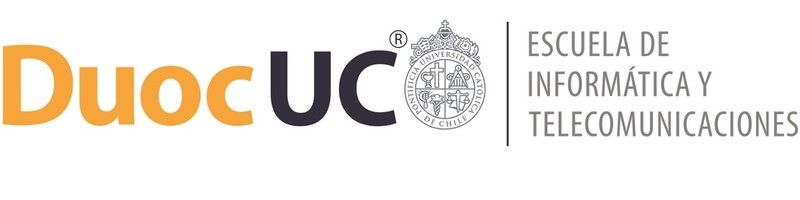

# **Informe Técnico - Caso Counter Strike**

# **Fase 1: Entendimiento del Negocio**

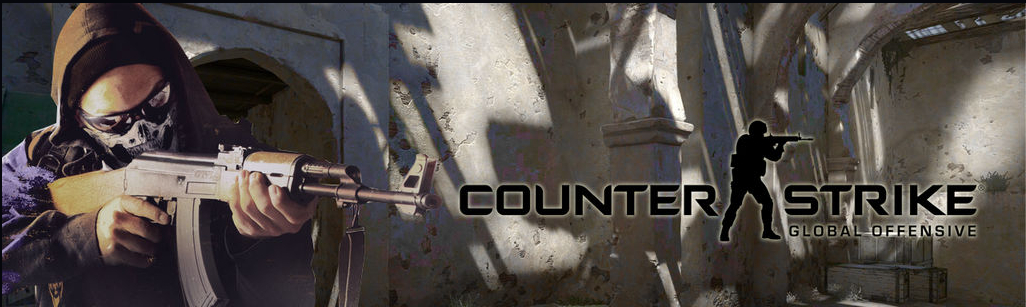

## **Contexto del Caso**
Valve Software nos ha contactado como equipo de análisis de datos y modelado de Machine Learning para analizar y realizar modelos predictivos sobre los datos.

Para proceder se debe aplicar la metodologia de analisis de datos CRISP-DM, partiendo inicialmente por la comprensión del negocio y el entendimiento de los datos.

El caso consiste en un set de datos que contiene datos de jugadores de Counter Strike GO.

En cada partida de Counter Strike: GO dos equipos de 5 jugadores (denominados terroristas y contra-terroristas) se enfrentan.

El objetivo del equipo terrorista es plantar una bomba con timer de 45 segundos en uno de dos sitios específicos dentro de un mapa. Por otro lado, el objetivo del equipo contra-terrorista es evitar que la bomba sea plantada o desactivarla antes de que esta explote cuando ya ha sido plantada. Los datos a utilizar corresponden a sobre 7000 partidas del juego (con un máximo de 10 jugadores c/u)  

Los datos han sido extraídos de replays, los cuales son archivos propietarios con la información de cada una de las acciones realizadas por cada jugador dentro de una partida. Los replays han sido extraídos de la red utilizando un scrapper y pre-procesados utilizando un script.  



En este caso, la data corresponde a un archivo CSV con 79.157 filas, cada una correspondiente a un jugador dentro de una partida. El archivo contiene 29 columnas correspondientes a variables que describen las acciones del jugador dentro del juego.


# **Fase 2 : Entendimiento de los Datos**

## **Subida y visualización de Dataframe**

In [ ]:
# Importación de las librerías básicas:

import pandas as pd                 #Libreria para manejo y análisis de datos
import matplotlib.pyplot as plt     #Libreria para gráficos
import seaborn as sns               #Libreria para gráficos avanzados
import numpy as np                  #Libreria para cálculos numéricos

#Librerias para modelos y métricas de regresión
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import svm
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#Librerias para modelos y métricas de clasificación

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.metrics import classification_report
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler


#Librería para puesta en producción
import pickle as pickle
from joblib import dump

# Configuración de advertencias
import warnings
warnings.filterwarnings('ignore')   # Para evitar los molestos avisos.
%matplotlib inline


In [ ]:
#Carga y lectura del set de datos .csv

#Para Colab------------------------------------------

#from google.colab import files
#uploaded = files.upload()
#for fn in uploaded.keys():
#    name=fn
#df = pd.read_csv(name, sep=";")


#Carga para Jupyter----------------------------------------
#df = pd.read_csv("Anexo ET_demo_round_traces.csv",  sep=";")

#Carga Desde Drive ---------------------------------
from google.colab import drive
drive.mount('/gdrive')

ruta = "/gdrive/MyDrive/Anexo ET_demo_round_traces.csv"
df = pd.read_csv(ruta, sep=";")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#Muestra del set de datos

df.head()

,Unnamed: 0,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,...,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
0,600,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,750,4400,0,0,0,0
1,601,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,800,4400,0,0,0,0
2,602,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,1000,4400,0,0,0,0
3,603,de_inferno,Terrorist,1,4,1,False,True,False,False,...,0,0,0,0,850,4400,0,0,0,0
4,604,de_inferno,Terrorist,1,4,1,False,True,True,False,...,0,0,0,0,1000,4400,0,0,0,0


In [ ]:
#Informacion de las variables.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79157 entries, 0 to 79156
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   79157 non-null  int64  
 1   Map                          79157 non-null  object 
 2   Team                         79155 non-null  object 
 3   InternalTeamId               79157 non-null  int64  
 4   MatchId                      79157 non-null  int64  
 5   RoundId                      79157 non-null  int64  
 6   RoundWinner                  79157 non-null  object 
 7   MatchWinner                  79156 non-null  object 
 8   Survived                     79157 non-null  bool   
 9   AbnormalMatch                79157 non-null  bool   
 10  TimeAlive                    79157 non-null  object 
 11  TravelledDistance            79157 non-null  object 
 12  RLethalGrenadesThrown        79157 non-null  int64  
 13  RNonLethalGrenad

### Observaciones:

*   Las variables de tipo booleano y object son **categóricas**.
*   Las variables de tipo int64 son **cuantitativas**.

Saber esta información es clave para elaborar el diccionario de datos.



## **Diccionario de Datos**


*   **Map:** Nombre  del Mapa donde se jugó la partida. **(Variable categórica nominal)**
*   **Team:** Nombre de equipo al que pertenece el jugador. **(Variable categórica nominal)**
*   **InternalTeamId:** Identificador del equipo al que pertenece el jugador. **(Variable categórica ordinal)**
*   **MatchId:** Identificador de la partida. **(Variable categórica ordinal)**
*   **RoundId:** Identificador de la ronda (los equipos se enfrentan en rondas de 5 partidas seguidas. **(Variable categórica ordinal)**
*   **MatchWinner:** Indica si el jugador ganó o no la partida. **(Variable categórica binaria)**
*   **RoundWinner:** Indica si el jugador ganó o no la ronda analizada. **(Variable categórica binaria)**
*   **Survived:** Indica si el jugador sobrevivió o no a la partida (sobrevivir no es sinónimo de ganar). **(Variable categórica binaria)**
*   **AbnormalMatch:** Indica si la partida del jugador tuvo un error por conexión de red. **(Variable categórica binaria)**
*   **TimeAlive:** Indica el tiempo en segundos que el jugador estuvo vivo durante el juego **(Variable cuantitativa continua)**
*   **TravelledDistance:** Distancia viajada por el jugador durante la partida. **(Variable cuantitativa continua)**
*   **RLethalGrenadesThrown:** Cantidad de granadas letales lanzadas. **(Variable cuantitativa discreta)**
*   **RNonLethalGrenadesThrown:** Cantidad de granadas no-letales lanzadas. **(Variable cuantitativa discreta)**
*   **PrimaryXXXX:** Porcentaje de uso arma clasificada como primaria. Categorizada en AssaultRifle, SniperRifle, SMG, Heavy y Pistol. **(Variable cuantitativa continua)**
*   **[Match|Round] Assists:** Cantidad de asistencias efectuadas por el jugador durante la partida o la ronda. **(Variable cuantitativa discreta)**
*   **[Match|Round] Kills:** Cantidad de kills efectuados por el jugador durante la partida o la ronda. **(Variable cuantitativa discreta)**
*   **[Match|Round] FlankKills:** Cantidad de kills efectuados por el jugador sin que la víctima lo viese durante la partida o la ronda. **(Variable cuantitativa discreta)**
*   **[Match|Round] HeadShots:** Cantidad de kills efectuados por el jugador a través de un tiro en la cabeza durante la partida o la ronda. **(Variable cuantitativa discreta)**
*   **RoundStartingEquipmentValue:** Valor del equipamiento llevado por el jugador al inicio de la ronda. **(Variable cuantitativa continua)**
*   **TeamStartingEquipmentValue:** Valor promedio del equipamiento llevado por el equipo del jugador al inicio de la ronda. **(Variable cuantitativa continua)**

## **Datos Estadisticos**

In [ ]:
#Descripción de Todos los Datos Estadísticos

df.describe()

,Unnamed: 0,InternalTeamId,MatchId,RoundId,RLethalGrenadesThrown,RNonLethalGrenadesThrown,PrimaryAssaultRifle,PrimarySniperRifle,PrimaryHeavy,PrimarySMG,...,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
count,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000,...,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000,79157.000000
mean,60570.193640,1.500006,250.525033,12.765517,0.498667,1.258057,0.675363,0.089840,0.005964,0.007046,...,0.671349,0.146178,0.301553,0.095633,3778.108695,18890.133532,8.511578,1.209912,1.874831,3.858484
std,36436.598386,0.500003,149.557804,7.432837,0.597985,1.184909,0.464125,0.279797,0.075497,0.082453,...,0.881798,0.385601,0.578843,0.320641,2111.285406,9743.203024,6.195079,1.435150,1.824027,3.246752
min,600.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30830.000000,1.000000,128.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1600.000000,10900.000000,3.000000,0.000000,0.000000,1.000000
50%,56720.000000,2.000000,236.000000,12.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,4700.000000,22550.000000,8.000000,1.000000,1.000000,3.000000
75%,90639.000000,2.000000,373.000000,19.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,5200.000000,26050.000000,13.000000,2.000000,3.000000,6.000000
max,123779.000000,2.000000,511.000000,36.000000,4.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,4.000000,5.000000,5.000000,8850.000000,36150.000000,41.000000,11.000000,14.000000,22.000000


## **Descripción de los Datos**

###   **Map:**


In [ ]:
df.Map.describe()

count          79157
unique             4
top       de_inferno
freq           28869
Name: Map, dtype: object

In [ ]:
df.Map.mode()

0    de_inferno
Name: Map, dtype: object

En la columna categórica del Mapa de juego, se puede describir e interpretar lo siguiente:

Hay cuatro valores únicos en la columna Map, lo que significa que los jugadores jugaron en cuatro mapas diferentes en Counter Strike.
El mapa "de_inferno" es el más frecuente, este mapa es el más popular debido a que se repite en 28,869 registros de jugadores.

### **Team:**


In [ ]:
df.Team.describe()

count         79155
unique            2
top       Terrorist
freq          39591
Name: Team, dtype: object

In [ ]:
df.Team.mode()

0    Terrorist
Name: Team, dtype: object

En la columna del equipo, se puede describir e interpretar lo siguiente:

Existen sólo dos categorías: Terroristas y ContraTerroristas.
El equipo "Terrorista" es la elección más popular entre los jugadores debido a que se repite 39.591 veces.

### **MatchWinner:**


In [ ]:
df.MatchWinner.describe()

count     79156
unique        2
top       False
freq      42017
Name: MatchWinner, dtype: object

In [ ]:
df.MatchWinner.mode()

0    False
Name: MatchWinner, dtype: object

Esta columna categórica MatchWinner indica si el jugador ganó o perdió la partida.
El valor más frecuente en la columna MatchWinner es False, su frecuencia es de 42,017, lo que explica que la mayoría de jugadores registrados no ganaron la partida.

### **RoundWinner:**


In [ ]:
df.RoundWinner.describe()

count     79157
unique        5
top       False
freq      23195
Name: RoundWinner, dtype: object

In [ ]:
df.RoundWinner.mode()

0    False
Name: RoundWinner, dtype: object

Esta columna categórica RoundWinner indica si el jugador ganó o perdió la ronda.
El valor más frecuente en la columna RoundWinner es False, su frecuencia es de 23195, lo que explica que la mayoría de jugadores registrados no ganaron la ronda.

### **Survived:**


In [ ]:
df.Survived.describe()

count     79157
unique        2
top       False
freq      47214
Name: Survived, dtype: object

In [ ]:
df.Survived.mode()

0    False
Name: Survived, dtype: bool

Esta columna categórica Survived indica si el jugador sobrevivió a la partida.
El valor más frecuente en la columna Survived es False, su frecuencia es de 47214, lo que explica que la mayoría de jugadores registrados no lograron sobrevivir hasta el fin de la partida.

### **AbnormalMatch:**

In [ ]:
df.AbnormalMatch.describe()

count     79157
unique        1
top       False
freq      79157
Name: AbnormalMatch, dtype: object

In [ ]:
df.AbnormalMatch.mode()

0    False
Name: AbnormalMatch, dtype: bool

Esta columna categórica AbnormalMatch indica si el jugador obtuvo error de red durante la duración de la partida.
El valor más frecuente en la columna Survived es False, su frecuencia es de 79157 del total de datos que son 79157, lo que significa que de todos los jugadores, ninguno obtuvo conexión de red.

### **TimeAlive:**


In [ ]:
df.TimeAlive.describe()

count     79157
unique    51627
top         0.0
freq         68
Name: TimeAlive, dtype: object

In [ ]:
df.TimeAlive.mode()

0    0.0
Name: TimeAlive, dtype: object

Esta columna categórica TimeAlive indica el tiempo de vida total que se tuvo en una partida de cada jugador. el tiempo de vida mas repetido 68, todos los jugadores registran algun tiempo de vida

### **TravelledDistance:**

In [ ]:
df.TravelledDistance.describe()

count     79157
unique    78001
top         0.0
freq        272
Name: TravelledDistance, dtype: object

In [ ]:
df.TravelledDistance.mode()

0    0.0
Name: TravelledDistance, dtype: object

Esta columna categórica TravelledDistance indica la distancia recorrida por los jugadores en cada ronda la distancia mas repitio en 272 rondas.

### **RLethalGrenadesThrown:**


In [ ]:
df.RLethalGrenadesThrown.describe()

count    79157.000000
mean         0.498667
std          0.597985
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          4.000000
Name: RLethalGrenadesThrown, dtype: float64

In [ ]:
df.RLethalGrenadesThrown.mode()

0    0
Name: RLethalGrenadesThrown, dtype: int64

In [ ]:
df.RLethalGrenadesThrown.median()

0.0

La variable RLethalGrenadesThrown indica la cantidad de granadas letales lanzadas por cada jugador en cada partida, se puede describir e interpretar lo siguiente:
El promedio de granadas letales lanzadas por cada jugador en cada partida es de 0.498667.
La desviación estándar de la cantidad de granadas letales lanzadas por cada jugador en cada partida es de 0.597985, esto quiere decir hay una amplia variabilidad en la cantidad de granadas letales lanzadas por cada jugador.

El valor mínimo de granadas letales lanzadas por un jugador en una partida es 0, lo que sugiere que algunos jugadores no lanzaron ninguna granada letal en una partida.

El 25% de los jugadores lanzaron 0 granadas letales en una partida.
El 50% de los jugadores lanzaron 0 granadas letales en una partida.
El 75% de los jugadores lanzaron 1 granada letal en una partida.
El valor máximo de granadas letales lanzadas por un jugador en una partida es 4, lo que sugiere que algunos jugadores lanzaron varias granadas letales en una partida.

La mayoría de los jugadores lanzaron pocas o ninguna granada letal en una partida, mientras que un pequeño porcentaje de jugadores lanzaron varias granadas letales en una partida.

### **RNonLethalGrenadesThrown:**


In [ ]:
df.RNonLethalGrenadesThrown.describe()

count    79157.000000
mean         1.258057
std          1.184909
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: RNonLethalGrenadesThrown, dtype: float64

In [ ]:
df.RNonLethalGrenadesThrown.median()

1.0

In [ ]:
df.RNonLethalGrenadesThrown.mode()

0    0
Name: RNonLethalGrenadesThrown, dtype: int64

RNonLethalGrenadesThrown se refiere a la cantidad de granadas no letales lanzadas por cada jugador en cada partida, podemos interpretar lo siguiente:

El promedio de granadas no letales lanzadas por cada jugador durante cada partida es de 1.26.

La desviación estándar de la cantidad de granadas no letales lanzadas es de aproximadamente 1.18, lo que indica una dispersión moderada de los datos.
La cantidad mínima de granadas no letales lanzadas es 0 y la cantidad máxima es 6.

El 25% de los jugadores no lanzaron granadas no letales en la partida.

El 75% lanzó 2 o menos granadas no letales.

El 50% (o la mediana) de granadas no letales lanzadas por cada jugador en cada partida es de 1, lo que indica que la mitad de los jugadores lanzó una cantidad de granadas no letales igual o menor a 1.

El 100% de los jugares lanzó un total de 6 granadas.

### **PrimaryAssaultRifle**


In [ ]:
df.PrimaryAssaultRifle.describe()

count    79157.000000
mean         0.675363
std          0.464125
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: PrimaryAssaultRifle, dtype: float64

In [ ]:
df.PrimaryAssaultRifle.mode()

0    1.0
Name: PrimaryAssaultRifle, dtype: float64

In [ ]:
df.PrimaryAssaultRifle.median()

1.0

PrimaryAssaultRifle se refiere al porcentaje de elección de rifle de asalto primario por cada jugador en cada partida:

El promedio de elección de rifle de asalto como arma primaria es del 67.5%.

La desviación estándar de las elecciones de arma de asalto primaria es de 0.464, lo que indica que la mayoría de los jugadores eligen un arma de asalto primaria en la mayoría de las partidas.

El valor mínimo de la elección de arma de asalto primaria es 0, lo que indica que algunos jugadores nunca eligen un arma de asalto primaria.

El 25% de las elecciones de arma de asalto primaria son 0, lo que indica que el 25% de los jugadores nunca eligen un arma de asalto primaria.

El 50%, 75% y 100% de los jugadores selecciona un rifle de asalto primario, lo que indica que una gran cantidad los jugadores si elige un rifle de asalto como arma primaria en cada partida.

### **PrimarySniperRifle**

In [ ]:
df.PrimarySniperRifle.describe()

count    79157.000000
mean         0.089840
std          0.279797
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: PrimarySniperRifle, dtype: float64

In [ ]:
df.PrimarySniperRifle.mode()

0    0.0
Name: PrimarySniperRifle, dtype: float64

In [ ]:
df.PrimarySniperRifle.median()

0.0

PrimarySnipertRifle se refiere al porcentaje de elección del Sniper rifle primario por cada jugador en cada partida:

El promedio de elección de rifle de asalto como arma primaria es del 8.9%.

La desviación estándar de las elecciones de arma de asalto primaria es de 0.279, lo que indica que la mayoría de los jugadores no eligen un arma de asalto primaria en la mayoría de las partidas.

El valor mínimo de la elección de arma de Sniper rifle primario es 0, lo que indica que algunos jugadores nunca eligen un arma de asalto primaria.

El 25% de las elecciones de arma Sniper rifle primario son 0, lo que indica que el 25% de los jugadores nunca eligen un arma de sniper primaria.

Los cuartiles indican que la seleccion de Sniper rifle primario esta por debajo de 25%.

### **PrimaryHeavy**

In [ ]:
df.PrimaryHeavy.describe()

count    79157.000000
mean         0.005964
std          0.075497
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: PrimaryHeavy, dtype: float64

In [ ]:
df.PrimaryHeavy.mode()

0    0.0
Name: PrimaryHeavy, dtype: float64

In [ ]:
df.PrimaryHeavy.median()

0.0

PrimaryHeavy se refiere al porcentaje de elección de la arma pesada como arma por cada jugador en cada partida:

El promedio de elección de PrimaryHeavy como arma primaria es del 0.005964%.

La desviación estándar de las elecciones de arma de PrimaryHeavy es de 0.754, lo que indica que la mayoría de los datos estan arriba de la media

El valor mínimo de la elección de arma de PrimaryHeavy es 0, lo que indica que algunos jugadores nunca eligen un arma de asalto primaria.

El 25% de las elecciones de arma PrimaryHeavy son 0, lo que indica que el 25% de los jugadores nunca eligen un arma de PrimaryHeavy.

Los cuartiles indican que la seleccion de PrimaryHeavy esta por debajo de 25%


### PrimarySMG

In [ ]:
df.PrimarySMG.describe()

count    79157.000000
mean         0.007046
std          0.082453
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: PrimarySMG, dtype: float64

In [ ]:
df.PrimarySMG.mode()

0    0.0
Name: PrimarySMG, dtype: float64

In [ ]:
df.PrimarySMG.median()

0.0

PrimarySMG se refiere al porcentaje de elección de la arma primaria SMG elegida por cada jugador en cada partida:

El promedio de elección de PrimarySMG como arma primaria es del 0.007046%.

La desviación estándar de las elecciones de arma de PrimarySMG es de 0.082453, lo que indica que la mayoría de los datos estan arriba de la media s.

El valor mínimo de la elección de arma de PrimarySMG es 0, lo que indica que algunos jugadores nunca eligen un arma de asalto primaria.

El 25% de las elecciones de arma PrimarySMG son 0, lo que indica que el 25% de los jugadores nunca eligen un arma de PrimarySMG.

Los cuartiles indican que la seleccion de PrimarySMG esta por debajo de 25%


### **PrimaryPistol**

In [ ]:
df.PrimaryPistol.describe()

count    79157.000000
mean         0.221787
std          0.415451
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: PrimaryPistol, dtype: float64

In [ ]:
df.PrimaryPistol.mode()

0    0
Name: PrimaryPistol, dtype: int64

In [ ]:
df.PrimaryPistol.median()

0.0

PrimaryPistol se refiere al porcentaje de elección de la pistola como arma por cada jugador en cada partida:

El promedio de elección de PrimaryPistol como arma primaria es del 22%.

La desviación estándar de las elecciones de arma de PrimaryPistol es de 0.415451, lo que indica que la mayoría de los datos estan arriba de la media

El valor mínimo de la elección de arma de PrimaryPistol es 0, lo que indica que algunos jugadores nunca eligen un arma de asalto primaria.

El 25% de las elecciones de arma PrimaryPistol son 0, lo que indica que el 25% de los jugadores nunca eligen un arma de PrimaryPistol.

Los cuartiles indican que la seleccion de PrimaryPistol esta por debajo de 25%


### **RoundKills**

In [ ]:
df.PrimaryPistol.describe()

count    79157.000000
mean         0.221787
std          0.415451
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: PrimaryPistol, dtype: float64

In [ ]:
df.PrimaryPistol.mode()

0    0
Name: PrimaryPistol, dtype: int64

In [ ]:
df.PrimaryPistol.median()

0.0

Esta columna categórica “Roundkills” indica cuantas kills realizo el jugador por cada ronda. Mostrando que la máxima cantidad de kills fue de 1 por ronda, ademas se obtuvo una media de 0.2 kills por ronda.

### **RoundAssists**

In [ ]:
df.RoundAssists.describe()

count    79157.000000
mean         0.146178
std          0.385601
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: RoundAssists, dtype: float64

In [ ]:
df.RoundAssists.mode()

0    0
Name: RoundAssists, dtype: int64

In [ ]:
df.RoundAssists.median()

0.0

Esta columna entrega cuantas asistencias de kill realizo el jugador por ronda entregando un máximo de 4 asistencias por rondas y una media de 0.14 asistencias por ronda jugada.

### **RoundHeadshots**

In [ ]:
df.RoundAssists.describe()

count    79157.000000
mean         0.146178
std          0.385601
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: RoundAssists, dtype: float64

In [ ]:
df.RoundAssists.mode()

0    0
Name: RoundAssists, dtype: int64

In [ ]:
df.RoundAssists.median()

0.0

Esta columna categórica indica cuantas rondas el jugador realizo kills con headshots mostrando que la máxima cantidad de headshots por ronda fue de 5 por lo cual el jugador en esa ronda mato al equipo completo de headshot, además se obtuvo una media de 0.3 headshots por rondas.

### **RoundFlankKills**


In [ ]:
df.RoundFlankKills.describe()

count    79157.000000
mean         0.095633
std          0.320641
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: RoundFlankKills, dtype: float64

In [ ]:
df.RoundAssists.mode()

0    0
Name: RoundAssists, dtype: int64

In [ ]:
df.RoundAssists.median()

0.0

Esta columna indica cuantas kills realizo el jugador sin que el contrario lo viera o lo localizara en su pantalla mostrando que la cantidad máxima de flankills fue de 5, además se obtuvo una media de 0.09 flankills por ronda.

### **RoundStartingEquipmentValue**


In [ ]:
df.RoundStartingEquipmentValue.describe()

count    79157.000000
mean      3778.108695
std       2111.285406
min          0.000000
25%       1600.000000
50%       4700.000000
75%       5200.000000
max       8850.000000
Name: RoundStartingEquipmentValue, dtype: float64

In [ ]:
df.RoundStartingEquipmentValue.mode()

0    4700
Name: RoundStartingEquipmentValue, dtype: int64

In [ ]:
df.RoundStartingEquipmentValue.median()

4700.0

De los datos estadísticos del Valor del equipamiento llevado por el jugador al inicio de la ronda, se puede interpretar lo siguiente:

El valor promedio del equipamiento llevado por los jugadores es de $3778.

Su desviación estándar (std) indica que los valores se distribuyen en un rango de 2111.2 con respecto a la media.

El valor mínimo en esta columna es 0, lo que señala que varios jugadores no llevan equipamiento valioso al inicio de la ronda.

El 25% de los jugadores tiene un equipaje de $1600.
El 50% (o la mediana) de los jugadores tiene un valor de equipaje de 4700 al inicio de la ronda.

El 75% cuenta con un valor de equipaje de $5200 al inicio de la ronda.

El valor máximo del valor de equipaje que tienen algunos jugadores es de $8850.


### **TeamStartingEquipmentValue**

In [ ]:
df.TeamStartingEquipmentValue.describe()

count    79157.000000
mean     18890.133532
std       9743.203024
min          0.000000
25%      10900.000000
50%      22550.000000
75%      26050.000000
max      36150.000000
Name: TeamStartingEquipmentValue, dtype: float64

In [ ]:
df.TeamStartingEquipmentValue.mode()

0    23500
Name: TeamStartingEquipmentValue, dtype: int64

In [ ]:
df.TeamStartingEquipmentValue.median()

22550.0

Del Valor del equipamiento llevado por cada equipo al inicio de la ronda se puede interpretar lo siguiente:

El promedio del valor del equipamiento llevado por cada equipo al inicio de la ronda es de $18,890.

Su desviación estándar es de 9,743.20, lo que indica una alta variabilidad en los valores.

El valor mínimo del equipamiento es 0, lo que puede indicar que algunos equipos iniciaron la ronda sin equipamiento o que hubo algún problema en la medición.

El 25% de los equipos contaban con un valor de hasta $10,900 en equipamiento al inicio de la ronda.

El 50% de los equipos contaban con un valor de hasta $22,550 en equipamiento al inicio de la ronda.

El 75% de los equipos contaban con un valor de hasta $26,050 en equipamiento al inicio de la ronda.

El valor máximo del equipamiento de un equipo 50,000, empezando la ronda con una buena cantidad de recursos.


### **MatchKills**

In [ ]:
df.MatchKills.describe()

count    79157.000000
mean         8.511578
std          6.195079
min          0.000000
25%          3.000000
50%          8.000000
75%         13.000000
max         41.000000
Name: MatchKills, dtype: float64

In [ ]:
df.MatchKills.mode()

0    2
Name: MatchKills, dtype: int64

In [ ]:
df.MatchKills.median()

8.0

Esta columna indica la cantidad de muertes por partida que efectuó cada jugador, en promedio cada jugador mata 8,5 enemigos.

### **MatchFlankKills**

In [ ]:
df.MatchKills.describe()

count    79157.000000
mean         8.511578
std          6.195079
min          0.000000
25%          3.000000
50%          8.000000
75%         13.000000
max         41.000000
Name: MatchKills, dtype: float64

In [ ]:
df.MatchKills.mode()

0    2
Name: MatchKills, dtype: int64

In [ ]:
df.MatchKills.median()

8.0

Esta variable hace refencia a la cantidad de muertes del jugador sin ser visto por la víctima. En promedio cada jugador efectúa 8,5 muertes de este tipo por partida.

### **MatchAssists**

In [ ]:
df.MatchAssists.describe()

count    79157.000000
mean         1.874831
std          1.824027
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         14.000000
Name: MatchAssists, dtype: float64

In [ ]:
df.MatchAssists.mode()

0    0
Name: MatchAssists, dtype: int64

In [ ]:
df.MatchAssists.median()

1.0

Esta columna indica cuantas asistencias se obtuvieron por jugador en cada partida contabilizando ronda por ronda mostrando un máximo de 14 asistencia por partida y una media de 1.8 asistencias por partidas.

### **MatchHeadshots**

In [ ]:
df.MatchHeadshots.describe()

count    79157.000000
mean         3.858484
std          3.246752
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         22.000000
Name: MatchHeadshots, dtype: float64

In [ ]:
df.MatchHeadshots.mode()

0    1
Name: MatchHeadshots, dtype: int64

In [ ]:
df.MatchHeadshots.median()

3.0

Esta columna indica cuantas kills por headshots realizo el jugador por partida mostrando una cantidad máxima de 22 headshots por partida y una media de 3.85 headshots por partida.

## **Gráficos y Análisis Estadísticos**

### Cantidad de mapas más seleccionados por los jugadores en cada partida

[Text(0, 0, 'de_inferno'),
 Text(1, 0, 'de_nuke'),
 Text(2, 0, 'de_mirage'),
 Text(3, 0, 'de_dust2')]

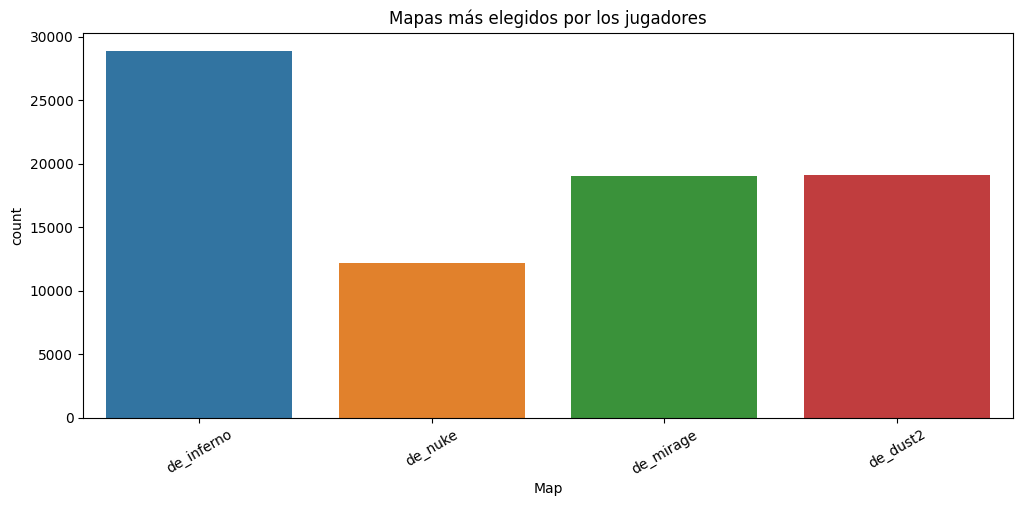

In [ ]:
# Gráfico de barras de los mapas
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5)) #Generar grilla para graficos
fig.subplots_adjust(hspace=0.5)

sns.countplot(x=df.Map, data=df, ax=ax)
ax.set_title("Mapas más elegidos por los jugadores")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

Observación: El mapa "de_inferno" es el mapa más elegido por los jugadores, siendo seleccionados 29000 veces aproximadamente.

El mapa de_nuke es el mapa menos elegido por los jugadores, siendo seleccionado unas 13000 veces aproximadamente.

### Cantidad de victorias y derrotas por cada jugador según su equipo en cada mapa

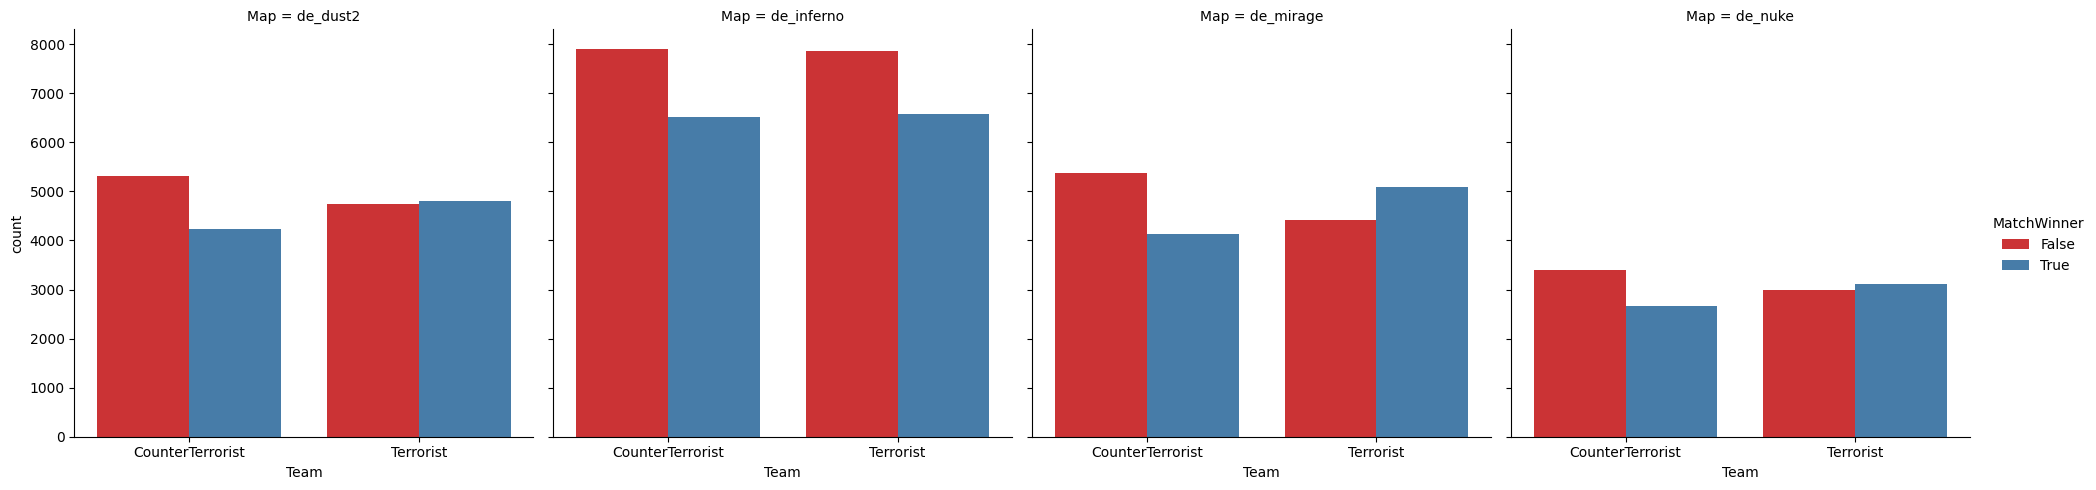

In [ ]:
import seaborn as sns

# Agrupar los datos por jugador, equipo y mapa y contar la cantidad de victorias y derrotas
grouped_df = df.groupby(['Team', 'Map', 'MatchWinner']).size().reset_index(name='count')

# Crear un gráfico de barras agrupado por equipo y mapa, y coloreado por el resultado de la partida
sns.catplot(x='Team', y='count', hue='MatchWinner', col='Map', data=grouped_df, kind='bar', palette='Set1')

Observaciones: En el mapa de_inferno, la cantidad de victorias y derrotas entre los equipos es equivalente, al ser un mapa muy popular, ambos bandos invierten tiempo en perfeccionarse por ganar la partida. En este mismo mapa, las derrotas son mayoritarias para ambos bandos.

### Cantidad de Victorias por Derrota

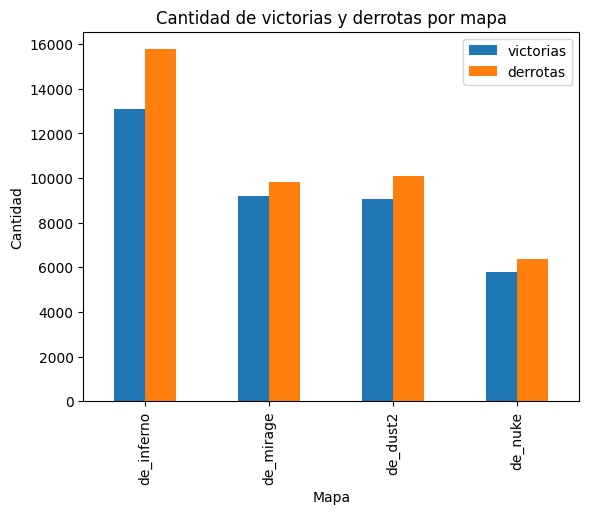

In [ ]:
import matplotlib.pyplot as plt

# contar la cantidad de victorias y derrotas por mapa
map_victories = df[df['MatchWinner'] == True]['Map'].value_counts()
map_losses = df[df['MatchWinner'] == False]['Map'].value_counts()

# unir los dos dataframes en uno solo
map_data = pd.concat([map_victories, map_losses], axis=1)
map_data.columns = ['victorias', 'derrotas']

# graficar los datos
map_data.plot(kind='bar')
plt.title('Cantidad de victorias y derrotas por mapa')
plt.xlabel('Mapa')
plt.ylabel('Cantidad')
plt.show()

## **Ejercicio de Calculo de probabilidad**

Calcularemos la probabilidad de ocurrencia de que un jugador gane un partida en base a la cantidad de granadas no letales lanzadas.

In [ ]:
#Importamos librería para cálculos estadisticos
import scipy.stats as st

#Seleccionamos y guardamos  las columnas "RNonLethalGrenadesThrown" y "MatchWinner"
granadas = df["RNonLethalGrenadesThrown"]
resultado = df["MatchWinner"]

#Dividimos los datos de granadas en grupos para un análisis de frecuencia.
bins = np.linspace(min(granadas), max(granadas), 10)
#Con la función cut de pandas dividimos los datos en intervalos:
groups = pd.cut(granadas, bins)

#Tabla de contingencia para los datos de grupos y resultados
tabla_contingencia = pd.crosstab(groups, resultado)

#Cálculo de probabilidad de ocurrencia de cada resultado para cada grupo.
#La función apply de pandas aplica una función a cada fila de la tabla de contingencia:
tabla_probabilidades = tabla_contingencia.apply(lambda r: r/r.sum(), axis=1)

#Con la función mean de pandas calculamos la probabilidad de que un jugador gane la partida:
probabilidad = df.loc[df["MatchWinner"] == True, "RNonLethalGrenadesThrown"].mean() / df["RNonLethalGrenadesThrown"].mean()
print(probabilidad)

0.9125275970731369


La probabilidad de que un jugador gane por arrojar una granada no letal es de un 91%

# **Fase 3 - Preparación de los Datos**

## **Preparación y formulación de hipótesis para problemas de Regresión**

### **Respaldo de Dataframe destinado a modelos de regresión.**

Como paso previo para la fase de modelación, haremos un respaldo del dataset original enfocada para las tareas de regresión.

In [ ]:
#Copia del dataframe
df_respaldo_reg = df.copy()

### **Creación de Nueva Variable**

Crearemos una nueva variable que servirá como variable predictora para los modelos de regresión que se aplicarán en la fase de modelamiento. Esta variable consiste en:

###**"El Porcentaje Promedio de Uso de Rifles de mediano y largo alcance como arma primaria "**

Esta variable se llamará "PrimaryMidLongRifle" y se calcula promediando las variables:

*   **PrimaryAssaultRifle:** Representa el porcentaje de elección de rifle de asalto como arma primaria.
*   **PrimarySniperRifle:** Representa el porcentaje de elección de rifle de francotirador como arma primaria.




In [ ]:
#Se promedia el porcentaje de elección entre rifle de asalto y rifle de francotirador. Este se almacena en una nueva columna

df_respaldo_reg['PrimaryMidLongRifle'] = df_respaldo_reg[['PrimaryAssaultRifle', 'PrimarySniperRifle']].mean(axis=1)

#### **Eliminación de columnas irrelevantes**

A continuación procedemos a eliminar  los ID de los registros, porque son columnas irrelevantes para las predicciones de regresión.

In [ ]:
#Eliminacion de columnas de ID
df_respaldo_reg = df_respaldo_reg.drop(columns=['InternalTeamId', 'MatchId', 'RoundId'])

Debido a la creación de la nueva variable "PrimaryMidLongRifle", eliminaremos las variables  originales **"PrimaryAssaultRifle"** y **"PrimarySniperRifle"**.

In [ ]:
#Eliminacion de columnas "PrimaryAssaultRifle" y "PrimarySniperRifle"
df_respaldo_reg = df_respaldo_reg.drop(columns=['PrimaryAssaultRifle', 'PrimarySniperRifle'])

También procedemos a la eliminación de columnas categóricas **irrelevantes** para el mapa de calor de correlaciones y los análisis de **regresión**.

**NOTA IMPORTANTE:** Para los futuros modelos de clasificación, las variables categóricas serán útiles, por esta razón se creó un respaldo del dataframe enfocado exclusivamente a los modelos de regresión.

In [ ]:
#Eliminacion de columnas categóricas
df_respaldo_reg = df_respaldo_reg.drop(columns=['Unnamed: 0', 'Map', 'Team', 'Survived', 'AbnormalMatch'])

In [ ]:
#Comprobación de columnas eliminadas
df_respaldo_reg.columns

Index(['RoundWinner', 'MatchWinner', 'TimeAlive', 'TravelledDistance',
       'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown', 'PrimaryHeavy',
       'PrimarySMG', 'PrimaryPistol', 'FirstKillTime', 'RoundKills',
       'RoundAssists', 'RoundHeadshots', 'RoundFlankKills',
       'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue',
       'MatchKills', 'MatchFlankKills', 'MatchAssists', 'MatchHeadshots',
       'PrimaryMidLongRifle'],
      dtype='object')

### **Mapa de Calor de Correlaciones**

Cómo último paso previo para crear los modelos de regresión, ya con el dataframe limpiado de columnas categóricas. Debemos verificar las correlaciones entre las variables, con el objetivo de definir correctamente la o las variables independientes que serán aplicadas al modelo de regresión para confirmar la hipótesis que formularemos en la fase de modelado.

In [ ]:
#Matriz de correlación

corrmat = df_respaldo_reg.corr()
corrmat

,RLethalGrenadesThrown,RNonLethalGrenadesThrown,PrimaryHeavy,PrimarySMG,PrimaryPistol,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,PrimaryMidLongRifle
RLethalGrenadesThrown,1.000000,0.382635,-0.023267,0.003408,-0.348568,0.162721,0.093738,0.080361,0.073273,0.438817,0.466507,0.110577,0.086692,0.106277,0.092965,0.345522
RNonLethalGrenadesThrown,0.382635,1.000000,-0.027057,-0.026666,-0.352804,0.148663,0.021319,0.100812,0.054749,0.368180,0.403791,0.099642,0.063542,0.073994,0.092548,0.356211
PrimaryHeavy,-0.023267,-0.027057,1.000000,-0.005862,-0.042170,0.001692,0.002628,-0.002897,0.008143,-0.037131,-0.022217,-0.009765,-0.000579,-0.002852,-0.004694,-0.135796
PrimarySMG,0.003408,-0.026666,-0.005862,1.000000,-0.045621,0.018592,0.012162,0.012835,0.001398,-0.025325,-0.013120,-0.021469,-0.013826,-0.010295,-0.016383,-0.148935
PrimaryPistol,-0.348568,-0.352804,-0.042170,-0.045621,1.000000,-0.195501,-0.055935,-0.079434,-0.075863,-0.792876,-0.828608,-0.147026,-0.095713,-0.102003,-0.116441,-0.964859
RoundKills,0.162721,0.148663,0.001692,0.018592,-0.195501,1.000000,-0.021482,0.679179,0.391406,0.172141,0.168600,0.183402,0.115988,0.019540,0.152600,0.187916
RoundAssists,0.093738,0.021319,0.002628,0.012162,-0.055935,-0.021482,1.000000,-0.017335,-0.000058,0.055227,0.067011,0.003477,0.008084,0.227472,-0.000812,0.052050
RoundHeadshots,0.080361,0.100812,-0.002897,0.012835,-0.079434,0.679179,-0.017335,1.000000,0.233419,0.035972,0.047938,0.112018,0.063589,0.004592,0.213817,0.075962
RoundFlankKills,0.073273,0.054749,0.008143,0.001398,-0.075863,0.391406,-0.000058,0.233419,1.000000,0.069842,0.076407,0.078891,0.248839,0.010769,0.062925,0.072717
RoundStartingEquipmentValue,0.438817,0.368180,-0.037131,-0.025325,-0.792876,0.172141,0.055227,0.035972,0.069842,1.000000,0.922943,0.179080,0.115976,0.112696,0.116417,0.789574


<Axes: >

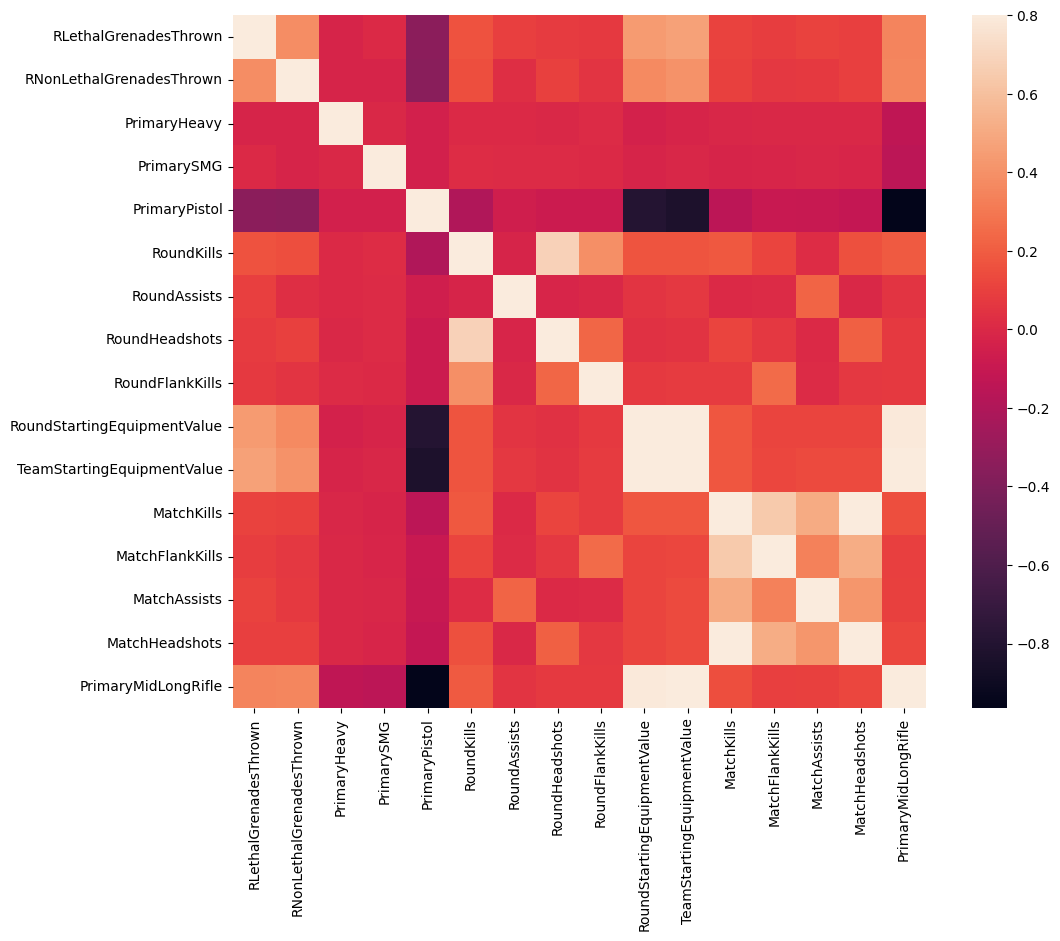

In [ ]:
#Heatmap (mapa de calor)

f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

#### **Selección de Variable Independiente**

En base a las correlaciones observadas en mapa de calor con respecto a 'PrimaryMidLongRifle', se observa que la variable **'RoundStartingEquipmentValue'**, que consiste en el valor del equipaje del jugador al inicio de la ronda, cuenta con una correlación de más del 80%.



Esto da pie para formular nuestra hipótesis a resolver en la siguiente fase:

### **Hipótesis: ¿Qué modelo predice de mejor forma el porcentaje (%) de uso de rifles como arma primaria en base al dinero inicial del jugador?**

## **Preparación y formulación de hipótesis para problemas de Clasificación**

Como paso previo para la fase de modelación, haremos un respaldo del dataset original enfocado para las tareas de **clasificación**.

In [ ]:
#Copia del dataframe
df_respaldo_clas = df.copy()

In [ ]:
df_respaldo_clas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79157 entries, 0 to 79156
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   79157 non-null  int64  
 1   Map                          79157 non-null  object 
 2   Team                         79155 non-null  object 
 3   InternalTeamId               79157 non-null  int64  
 4   MatchId                      79157 non-null  int64  
 5   RoundId                      79157 non-null  int64  
 6   RoundWinner                  79157 non-null  object 
 7   MatchWinner                  79156 non-null  object 
 8   Survived                     79157 non-null  bool   
 9   AbnormalMatch                79157 non-null  bool   
 10  TimeAlive                    79157 non-null  object 
 11  TravelledDistance            79157 non-null  object 
 12  RLethalGrenadesThrown        79157 non-null  int64  
 13  RNonLethalGrenad

### **Limpieza de futuras variables independientes a utilizar**

In [ ]:
#Insertamos valor sucedaneo en datos nulos de RLethalGrenadesThrown
arrSucedaneo = np.array([df_respaldo_clas[['RLethalGrenadesThrown']].mean(),
                         df_respaldo_clas[['RLethalGrenadesThrown']].mode(),
                         df_respaldo_clas[['RLethalGrenadesThrown']].median()])
sucedaneo = np.mean(arrSucedaneo)
df_respaldo_clas[['RLethalGrenadesThrown']] = df_respaldo_clas[['RLethalGrenadesThrown']].fillna(sucedaneo)

In [ ]:
#Insertamos valor sucedaneo en datos nulos de PrimaryAssaultRifle
arrSucedaneo = np.array([df_respaldo_clas[['PrimaryAssaultRifle']].mean(),
                         df_respaldo_clas[['PrimaryAssaultRifle']].mode(),
                         df_respaldo_clas[['PrimaryAssaultRifle']].median()])
sucedaneo = np.mean(arrSucedaneo)
df_respaldo_clas[['PrimaryAssaultRifle']] = df_respaldo_clas[['PrimaryAssaultRifle']].fillna(sucedaneo)

In [ ]:
df_respaldo_clas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79157 entries, 0 to 79156
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   79157 non-null  int64  
 1   Map                          79157 non-null  object 
 2   Team                         79155 non-null  object 
 3   InternalTeamId               79157 non-null  int64  
 4   MatchId                      79157 non-null  int64  
 5   RoundId                      79157 non-null  int64  
 6   RoundWinner                  79157 non-null  object 
 7   MatchWinner                  79156 non-null  object 
 8   Survived                     79157 non-null  bool   
 9   AbnormalMatch                79157 non-null  bool   
 10  TimeAlive                    79157 non-null  object 
 11  TravelledDistance            79157 non-null  object 
 12  RLethalGrenadesThrown        79157 non-null  int64  
 13  RNonLethalGrenad

### **Limpieza de Variable RoundWinner**

Se observa que en la columna hay valores mal escritos.

In [ ]:
df_respaldo_clas.RoundWinner.unique()

array(['False', 'True', 'False4', True, False], dtype=object)

Reemplazo por booleano.

In [ ]:
df_respaldo_clas.loc[df_respaldo_clas['RoundWinner']=='False4','RoundWinner'] = False
df_respaldo_clas.loc[df_respaldo_clas['RoundWinner']=='False','RoundWinner'] = False
df_respaldo_clas.loc[df_respaldo_clas['RoundWinner']=='True','RoundWinner'] = True
df_respaldo_clas.RoundWinner.unique()

array([False, True], dtype=object)

Convertir valores booleanos en valores numéricos para el correcto funcionamiento del modelo


In [ ]:
df_respaldo_clas['RoundWinner'] = df_respaldo_clas['RoundWinner'].astype(int)
df_respaldo_clas.RoundWinner.unique()

array([0, 1])

### **Limpieza de Variable MatchWinner**

Verificamos que existe un valor nulo.

In [ ]:
df_respaldo_clas.MatchWinner.unique()

array([True, False, nan], dtype=object)

Este registro será reemplazado por la moda, que en este caso es False.

In [ ]:
df_respaldo_clas.MatchWinner.mode()

0    False
Name: MatchWinner, dtype: object

In [ ]:
df_respaldo_clas[['MatchWinner']] = df_respaldo_clas[['MatchWinner']].fillna(False)

**Verificamos limpieza de la variable**

In [ ]:
df_respaldo_clas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79157 entries, 0 to 79156
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   79157 non-null  int64  
 1   Map                          79157 non-null  object 
 2   Team                         79155 non-null  object 
 3   InternalTeamId               79157 non-null  int64  
 4   MatchId                      79157 non-null  int64  
 5   RoundId                      79157 non-null  int64  
 6   RoundWinner                  79157 non-null  int64  
 7   MatchWinner                  79157 non-null  bool   
 8   Survived                     79157 non-null  bool   
 9   AbnormalMatch                79157 non-null  bool   
 10  TimeAlive                    79157 non-null  object 
 11  TravelledDistance            79157 non-null  object 
 12  RLethalGrenadesThrown        79157 non-null  int64  
 13  RNonLethalGrenad

### **Mapa de Correlación**

#### **Eliminación de columnas irrelevantes**

A continuación procedemos a eliminar  los ID de los registros, porque son columnas irrelevantes para las predicciones de clasificación.

In [ ]:
#Eliminacion de columnas de ID
df_respaldo_clas = df_respaldo_clas.drop(columns=['InternalTeamId', 'MatchId', 'RoundId'])

Debido a la creación de la nueva variable "PrimaryMidLongRifle", eliminaremos las variables  originales **"PrimaryAssaultRifle"** y **"PrimarySniperRifle"**.

También procedemos a la eliminación de columnas categóricas **irrelevantes** para nuestros análisis que buscan predecir la victoria o derrota del jugador.

In [ ]:
#Eliminacion de columnas categóricas
df_respaldo_clas = df_respaldo_clas.drop(columns=['Unnamed: 0', 'Map', 'AbnormalMatch'])

In [ ]:
#Matriz de correlación

corrmat = df_respaldo_clas.corr()
corrmat

,RoundWinner,MatchWinner,Survived,RLethalGrenadesThrown,RNonLethalGrenadesThrown,PrimaryAssaultRifle,PrimarySniperRifle,PrimaryHeavy,PrimarySMG,PrimaryPistol,RoundKills,RoundAssists,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots
RoundWinner,1.000000,0.229572,-0.359380,-0.222471,-0.142053,-0.202129,-0.059910,0.000225,-0.030218,0.272114,-0.269225,-0.121874,-0.154688,-0.126867,-0.302573,-0.327844,-0.084633,-0.059837,-0.069015,-0.064035
MatchWinner,0.229572,1.000000,-0.143498,-0.152949,-0.087315,-0.102798,-0.029833,0.011191,-0.029459,0.138747,-0.107748,-0.060194,-0.067321,-0.045294,-0.175747,-0.190423,-0.186289,-0.111142,-0.161660,-0.149788
Survived,-0.359380,-0.143498,1.000000,0.171732,0.125064,0.110008,0.067100,0.002006,0.026469,-0.173705,0.331619,-0.063264,0.205279,0.139673,0.170578,0.173237,0.059445,0.041533,-0.008001,0.047407
RLethalGrenadesThrown,-0.222471,-0.152949,0.171732,1.000000,0.382635,0.326426,-0.018635,-0.023267,0.003408,-0.348568,0.162721,0.093738,0.080361,0.073273,0.438817,0.466507,0.110577,0.086692,0.106277,0.092965
RNonLethalGrenadesThrown,-0.142053,-0.087315,0.125064,0.382635,1.000000,0.339062,-0.023421,-0.027057,-0.026666,-0.352804,0.148663,0.021319,0.100812,0.054749,0.368180,0.403791,0.099642,0.063542,0.073994,0.092548
PrimaryAssaultRifle,-0.202129,-0.102798,0.110008,0.326426,0.339062,1.000000,-0.440642,-0.108901,-0.119824,-0.776826,0.127903,0.065941,0.119863,0.063766,0.518780,0.627534,0.095224,0.087460,0.103451,0.142642
PrimarySniperRifle,-0.059910,-0.029833,0.067100,-0.018635,-0.023421,-0.440642,1.000000,-0.024840,-0.026602,-0.171415,0.072187,-0.030621,-0.083883,0.004260,0.334221,0.199256,0.069314,0.001269,-0.016344,-0.057624
PrimaryHeavy,0.000225,0.011191,0.002006,-0.023267,-0.027057,-0.108901,-0.024840,1.000000,-0.005862,-0.042170,0.001692,0.002628,-0.002897,0.008143,-0.037131,-0.022217,-0.009765,-0.000579,-0.002852,-0.004694
PrimarySMG,-0.030218,-0.029459,0.026469,0.003408,-0.026666,-0.119824,-0.026602,-0.005862,1.000000,-0.045621,0.018592,0.012162,0.012835,0.001398,-0.025325,-0.013120,-0.021469,-0.013826,-0.010295,-0.016383
PrimaryPistol,0.272114,0.138747,-0.173705,-0.348568,-0.352804,-0.776826,-0.171415,-0.042170,-0.045621,1.000000,-0.195501,-0.055935,-0.079434,-0.075863,-0.792876,-0.828608,-0.147026,-0.095713,-0.102003,-0.116441


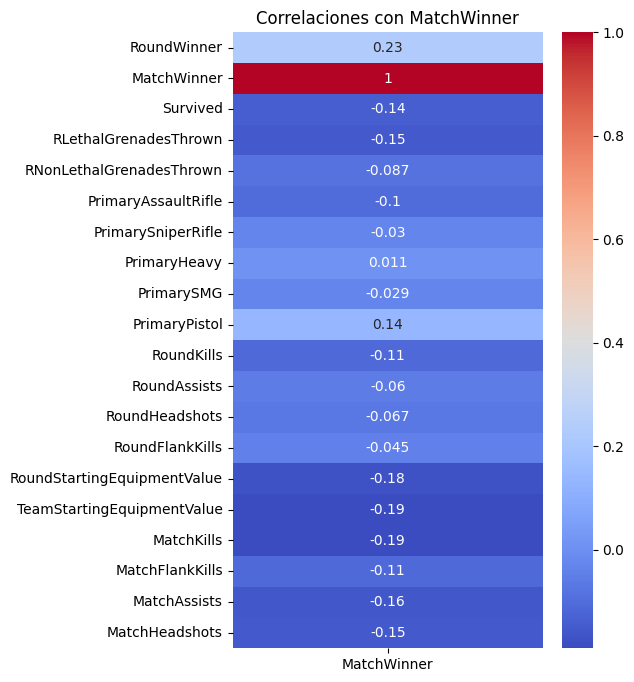

In [ ]:
# Calcular las correlaciones entre la columna de interés y las demás variables
correlaciones = df_respaldo_clas.corr()['MatchWinner']

# Crear un mapa de calor utilizando las correlaciones
plt.figure(figsize=(5, 8))
sns.heatmap(correlaciones.to_frame(), annot=True, cmap='coolwarm')
plt.title('Correlaciones con {}'.format('MatchWinner'))
plt.show()

<Axes: >

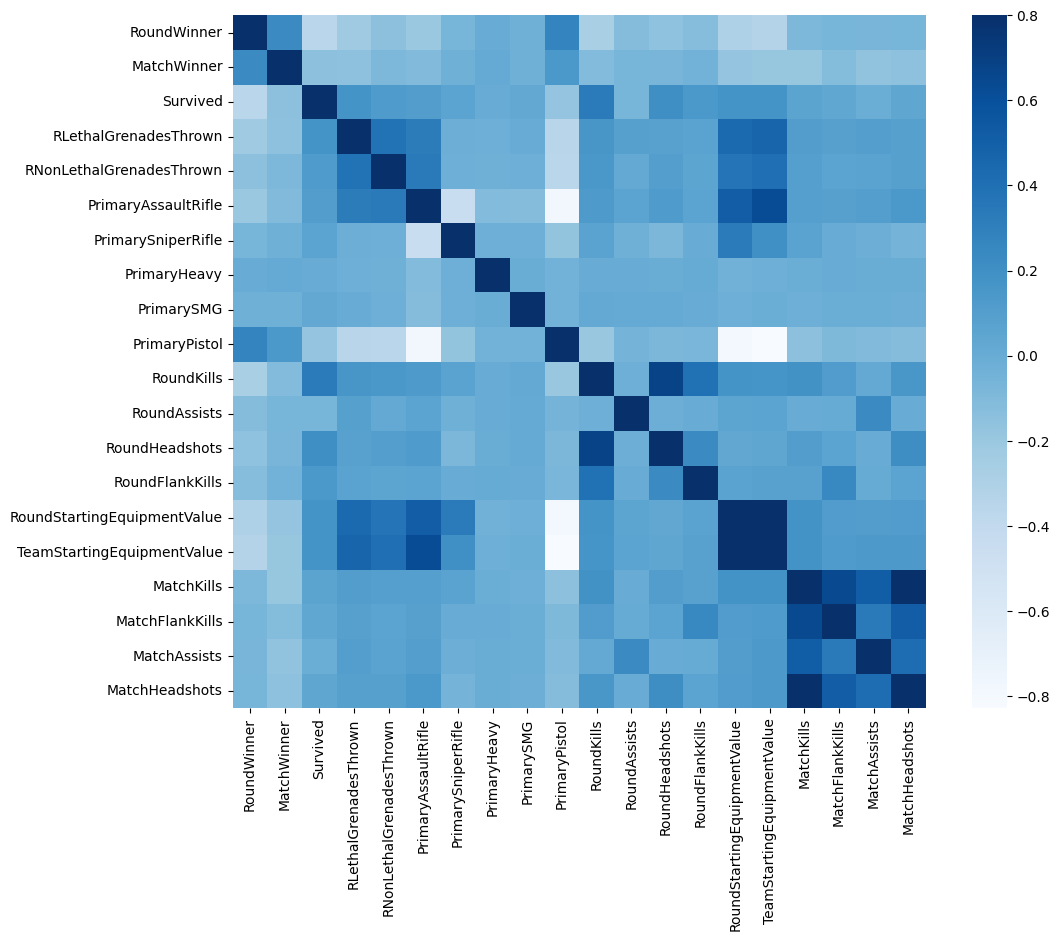

In [ ]:
#Heatmap (mapa de calor)

f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="Blues")

### **Hipótesis: ¿Qué modelo de clasificación predice de mejor forma si el jugador ganó la Partida?**

# **Fase 4 - Modelado**

## **Modelos de Regresión**

### **Modelo de Regresión Lineal Simple**

La distribución de los datos de entrenamiento y prueba es de un 80% y 20% respectivamente.

In [ ]:
#Definir las variables independientes (X) y la variable dependiente (y)
X = df_respaldo_reg[['RoundStartingEquipmentValue']]
y = df_respaldo_reg[['PrimaryMidLongRifle']]

#Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Crear el modelo de regresión lineal
reg_model = LinearRegression()

#Entrenar el modelo
reg_model.fit(X_train, y_train)

#Realizar predicciones en el conjunto de prueba
y_pred = reg_model.predict(X_test)

#Limitar las predicciones entre 0 y 1
y_pred_clipped = np.clip(y_pred, 0, 1)

#Asignación de variable exclusiva para el input
y_pred_reglineal = y_pred_clipped

#Escalar los valores a un rango de 0 a 100
y_pred_scaled = y_pred_clipped

#Asegurar que las predicciones no superen el 100%
y_pred_final = np.minimum(y_pred_scaled, 100)

#### **Cálculo de Métricas de Evaluación**

**Métricas del modelo de Entrenamiento**

In [ ]:
mse_train = mean_squared_error(y_train, reg_model.predict(X_train))
r2_train = r2_score(y_train, reg_model.predict(X_train))
mae_train = mean_absolute_error(y_train, reg_model.predict(X_train))
rmse_train = np.sqrt(mse_train)

print("Coeficiente de determinacion(R^2):", r2_train)
print("Error absoluto medio(MAE): ", mae_train)
print("Error cuadrático medio (MSE):", mse_train)
print("Error cuadrático medio(RMSE):", rmse_train)

Coeficiente de determinacion(R^2): 0.6215830338373018
Error absoluto medio(MAE):  0.09723486411977693
Error cuadrático medio (MSE): 0.0169711391227786
Error cuadrático medio(RMSE): 0.1302733246784567


**Métricas del modelo de Prueba**

In [ ]:
r2 = r2_score(y_test, y_pred_final)
mae = mean_absolute_error(y_test, y_pred_final)
mse = mean_squared_error(y_test, y_pred_final)
rmse = mean_squared_error(y_test, y_pred_final, squared=False)

print("Coeficiente de determinación (R^2):", r2)
print("Error absoluto medio (MAE):", mae)
print("Error cuadrático medio (MSE):", mse)
print("Raíz del error cuadrático medio (RMSE):", rmse)

Coeficiente de determinación (R^2): 0.6308233297960408
Error absoluto medio (MAE): 0.0960319388361224
Error cuadrático medio (MSE): 0.016492438401628395
Raíz del error cuadrático medio (RMSE): 0.12842288893195167


### **Modelo de Support Vector Regresion**

Se aplicó un kernel lineal para distinguir entre los valores predichos mayores y menores a 0.5 (50%).

La distribución de los datos de entrenamiento y prueba es de un 80% y 20% respectivamente.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Extraer las variables independiente y dependiente
X = df_respaldo_reg[['RoundStartingEquipmentValue']].values
y = df_respaldo_reg['PrimaryMidLongRifle'].values

# Escalar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Crear y entrenar el modelo SVR
model = SVR(kernel='linear')
model.fit(X_train, y_train)

# Realizar predicciones en los datos de prueba
y_pred = model.predict(X_test)

#Limitar las predicciones entre 0 y 1
y_pred_clipped = np.clip(y_pred, 0, 1)

# Clasificar las predicciones en dos grupos
y_pred_classified = np.where(y_pred_clipped < 0.5, 0, 1)

# Invertir la escala de las predicciones
y_pred = scaler.inverse_transform(y_pred_clipped.reshape(-1, 1)).ravel()

#Variable que será usada para el formulario de predicción
y_pred_svr = y_pred_final

# Graficar las predicciones clasificadas
plt.scatter(X_test[y_test < 0.5], y_pred_classified[y_test < 0.5], color='b', label='Menor a 0.5')
plt.scatter(X_test[y_test >= 0.5], y_pred_classified[y_test >= 0.5], color='r', label='Mayor o igual a 0.5')
plt.xlabel('RoundStartingEquipmentValue')
plt.ylabel('Clasificación (Menor a 0.5, Mayor o igual a 0.5)')
plt.legend()
plt.show()

#### **Resultados de métricas de evaluación:**


**Métricas del modelo de Entrenamiento**

In [ ]:
mse_train = mean_squared_error(y_train, reg_model.predict(X_train))
r2_train = r2_score(y_train, reg_model.predict(X_train))
mae_train = mean_absolute_error(y_train, reg_model.predict(X_train))
rmse_train = np.sqrt(mse_train)

print("Coeficiente de determinacion(R^2):", r2_train)
print("Error absoluto medio(MAE): ", mae_train)
print("Error cuadrático medio (MSE):", mse_train)
print("Error cuadrático medio(RMSE):", rmse_train)

**Métricas del modelo de Prueba**

In [ ]:
r2 = r2_score(y_test, y_pred_clipped)
mae = mean_absolute_error(y_test, y_pred_clipped)
mse = mean_squared_error(y_test, y_pred_clipped)
rmse = mean_squared_error(y_test, y_pred_clipped, squared=False)

print("Coeficiente de determinación (R^2):", r2)
print("Error absoluto medio (MAE):", mae)
print("Error cuadrático medio (MSE):", mse)
print("Raíz del error cuadrático medio (RMSE):", rmse)

### **Modelo de Árbol de Decisión de Regresión**

La distribución de los datos de entrenamiento y prueba es de un 80% y 20% respectivamente.

Se podó el árbol a 4 nodos con el propósito de evitar atomización.

In [ ]:
# Extraer las variables independiente y dependiente
X = df_respaldo_reg[['RoundStartingEquipmentValue']]
y = df_respaldo_reg['PrimaryMidLongRifle']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)
modelo = DecisionTreeRegressor(max_depth = 4, random_state = 42)

#Entrenar el modelo
modelo.fit(X_train, y_train)

# Realizar predicciones en los datos de prueba
Y_pred = modelo.predict(X_test)

#Limitar las predicciones entre 0 y 1
y_pred_clipped = np.clip(y_pred, 0, 1)

#Variable que será utilizada para el formulario de predicción
Y_pred_arbol = y_pred_clipped

print('Precisión del modelo (en entrenamiento):', modelo.score(X_train, y_train))
print('Precisión del modelo (en validación):', modelo.score(X_test, y_test))

In [ ]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(30, 10))
print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")
plot = plot_tree(

decision_tree = modelo,
feature_names = X.columns,
class_names = 'PrimaryMidLongRifle',
filled = True,
impurity = False,
fontsize = 10,
precision = 2,
ax = ax
)

#### **Cálculo de Métricas de Evaluación**

**Métricas del modelo de Entrenamiento**

In [ ]:
mse_train = mean_squared_error(y_train, reg_model.predict(X_train))
r2_train = r2_score(y_train, reg_model.predict(X_train))
mae_train = mean_absolute_error(y_train, reg_model.predict(X_train))
rmse_train = np.sqrt(mse_train)

print("Coeficiente de determinacion(R^2):", r2_train)
print("Error absoluto medio(MAE): ", mae_train)
print("Error cuadrático medio (MSE):", mse_train)
print("Error cuadrático medio(RMSE):", rmse_train)

**Métricas del modelo de Prueba**

In [ ]:
r2 = r2_score(y_test, Y_pred)
mae = mean_absolute_error(y_test, Y_pred)
mse = mean_squared_error(y_test, Y_pred)
rmse = mean_squared_error(y_test, Y_pred, squared=False)

print("Coeficiente de determinación (R^2):", r2)
print("Error absoluto medio (MAE):", mae)
print("Error cuadrático medio (MSE):", mse)
print("Raíz del error cuadrático medio (RMSE):", rmse)

## **Modelos de Clasificación**

### **1 - Random Forest de Clasificación**

In [ ]:
# Separar las características y la variable objetivo
X = df_respaldo_clas[['RLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimaryPistol']]
y = df_respaldo_clas['MatchWinner']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear una instancia de StandardScaler
scaler = StandardScaler()

# Ajustar y transformar los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# Transformar los datos de prueba
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de clasificación RandomForest con 100 árboles
rf_classifier = RandomForestClassifier(n_estimators=100)

# Entrenar el modelo con los datos escalados
rf_classifier.fit(X_train_scaled, y_train)

#Guardar el StandardScaler ajustado en el archivo scaler.joblib
dump(scaler, 'scaler.joblib')

['scaler.joblib']

**Métricas de Desempeño de Entrenamiento y Prueba**

In [ ]:
# Evaluar el modelo en los datos de entrenamiento
train_accuracy = rf_classifier.score(X_train_scaled, y_train)
y_train_pred = rf_classifier.predict(X_train_scaled)
train_cm = confusion_matrix(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Evaluar el modelo en los datos de prueba
test_accuracy = rf_classifier.score(X_test_scaled, y_test)
y_test_pred = rf_classifier.predict(X_test_scaled)
test_cm = confusion_matrix(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Imprimir las métricas de desempeño en entrenamiento
print("Métricas de entrenamiento:")
print("Train Matriz de Confusión:")
print(train_cm)
print("Train Accuracy:", train_accuracy)
print("Train Recall:", train_recall)
print("Train Precision:", train_precision)
print("Train F1 Score:", train_f1)
print("\n")
# Imprimir las métricas de desempeño en prueba
print("Métricas de prueba:")
print("Test Matriz de Confusión:")
print(test_cm)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1)

Métricas de entrenamiento:
Train Matriz de Confusión:
[[19077 14486]
 [10803 18959]]
Train Accuracy: 0.6006474536123174
Train Recall: 0.6370203615348431
Train Precision: 0.5668709822095979
Train F1 Score: 0.5999019095986204


Métricas de prueba:
Test Matriz de Confusión:
[[4578 3877]
 [2892 4485]]
Test Accuracy: 0.5724482061647297
Test Recall: 0.6079707198047987
Test Precision: 0.5363549390098062
Test F1 Score: 0.5699218501810788


#### **Reporte de Clasificación**

**Entrenamiento:**

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

       False       0.64      0.57      0.60     33563
        True       0.57      0.64      0.60     29762

    accuracy                           0.60     63325
   macro avg       0.60      0.60      0.60     63325
weighted avg       0.60      0.60      0.60     63325



**Prueba:**

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.61      0.54      0.57      8455
        True       0.54      0.61      0.57      7377

    accuracy                           0.57     15832
   macro avg       0.57      0.57      0.57     15832
weighted avg       0.58      0.57      0.57     15832



**Curva ROC de Entrenamiento y Prueba**

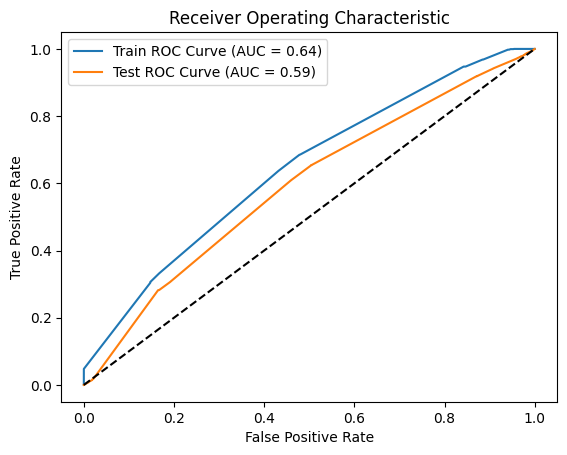

In [ ]:
# Calcula las probabilidades de predicción para las clases positivas del conjunto de entrenamiento y prueba:
y_train_probs = rf_classifier.predict_proba(X_train_scaled)[:, 1]
y_test_probs = rf_classifier.predict_proba(X_test_scaled)[:, 1]

# Calcula los valores de los puntos de la curva ROC para el conjunto de entrenamiento y prueba:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

# Calcula el área bajo la curva ROC para el conjunto de entrenamiento y prueba:
auc_train = roc_auc_score(y_train, y_train_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

#Graficar ROC
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC Curve (AUC = {:.2f})'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

### **1.1 Random Forest de Clasificación con Oversampling**

In [ ]:
# Concatenar las características y la variable objetivo
df_train = pd.concat([X_train, y_train], axis=1)

# Aplicar oversampling
oversampler = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Crear una instancia de StandardScaler
scaler = StandardScaler()

# Ajustar y transformar los datos de entrenamiento oversampled
X_train_oversampled_scaled = scaler.fit_transform(X_train_oversampled)

# Transformar los datos de prueba
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de clasificación RandomForest con 100 árboles para el oversampled
rf_classifier_oversampled = RandomForestClassifier(n_estimators=100)
rf_classifier_oversampled.fit(X_train_oversampled_scaled, y_train_oversampled)

# Evaluar el modelo en los datos de entrenamiento oversampled
train_accuracy_oversampled = rf_classifier_oversampled.score(X_train_oversampled_scaled, y_train_oversampled)
y_train_pred_oversampled = rf_classifier_oversampled.predict(X_train_oversampled_scaled)
train_cm_oversampled = confusion_matrix(y_train_oversampled, y_train_pred_oversampled)
train_recall_oversampled = recall_score(y_train_oversampled, y_train_pred_oversampled)
train_precision_oversampled = precision_score(y_train_oversampled, y_train_pred_oversampled)
train_f1_oversampled = f1_score(y_train_oversampled, y_train_pred_oversampled)

# Evaluar el modelo en los datos de prueba
test_accuracy = rf_classifier_oversampled.score(X_test_scaled, y_test)
y_test_pred = rf_classifier_oversampled.predict(X_test_scaled)
test_cm = confusion_matrix(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Imprimir las métricas de desempeño en entrenamiento oversampled
print("Métricas de entrenamiento oversampled:")
print("Train Matriz de Confusión oversampled:")
print(train_cm_oversampled)
print("Train Accuracy oversampled:", train_accuracy_oversampled)
print("Train Recall oversampled:", train_recall_oversampled)
print("Train Precision oversampled:", train_precision_oversampled)
print("Train F1 Score oversampled:", train_f1_oversampled)
print("\n")

# Imprimir las métricas de desempeño en prueba
print("Métricas de prueba:")
print("Test Matriz de Confusión:")
print(test_cm)
print("Test Accuracy:", test_accuracy)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)
print("Test F1 Score:", test_f1)

Métricas de entrenamiento oversampled:
Train Matriz de Confusión oversampled:
[[17529 16034]
 [10549 23014]]
Train Accuracy oversampled: 0.6039835533176414
Train Recall oversampled: 0.6856955576080803
Train Precision oversampled: 0.5893771768080311
Train F1 Score oversampled: 0.6338984451391663


Métricas de prueba:
Test Matriz de Confusión:
[[4194 4261]
 [2558 4819]]
Test Accuracy: 0.5692900454775139
Test Recall: 0.6532465771994036
Test Precision: 0.530726872246696
Test F1 Score: 0.5856474448562922


**Curva ROC de Entrenamiento y Prueba con Modelo Oversampleado**

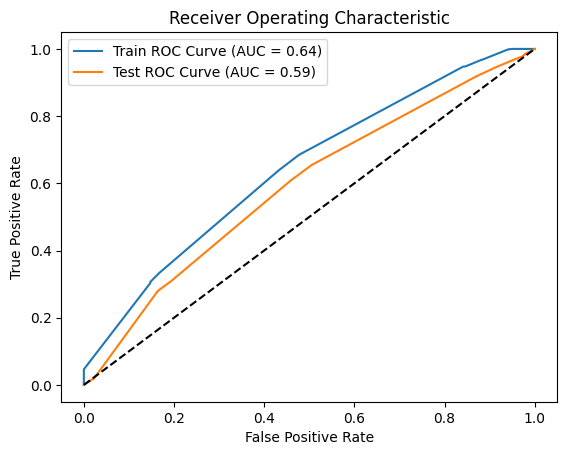

In [ ]:
# Calcula las probabilidades de predicción para las clases positivas del conjunto de entrenamiento y prueba:
y_train_probs = rf_classifier_oversampled.predict_proba(X_train_oversampled_scaled)[:, 1]
y_test_probs = rf_classifier_oversampled.predict_proba(X_test_scaled)[:, 1]

# Calcula los valores de los puntos de la curva ROC para el conjunto de entrenamiento y prueba:
fpr_train, tpr_train, _ = roc_curve(y_train_oversampled, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

# Calcula el área bajo la curva ROC para el conjunto de entrenamiento y prueba:
auc_train = roc_auc_score(y_train_oversampled, y_train_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

#Graficar ROC
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC Curve (AUC = {:.2f})'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

### **2 - KNN (K-Vecinos Más Cercanos)**

Para el modelo de KNN, se definió en 20 la cantidad de k-vecinos, con el propósito de tener una mejor precisión.

#### **Modelo**

In [ ]:
# Dividir los datos en variables independientes (X) y variable objetivo (y)
X = df_respaldo_clas[['RLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimaryPistol']]
y = df_respaldo_clas['MatchWinner']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de entrenamiento y prueba
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)

#Guardar el StandardScaler ajustado en el archivo scaler.joblib
dump(scaler, 'scaler.joblib')

# Calcular métricas de desempeño para el conjunto de entrenamiento y prueba
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Imprimir las métricas de desempeño
print("Métricas de entrenamiento:")
print("Matriz de Confusión:")
print(train_cm)
print("Accuracy:", train_accuracy)
print("Recall:", train_recall)
print("Precision:", train_precision)
print("F1 Score:", train_f1)
print("\n")
print("Métricas de prueba:")
print("Matriz de Confusión:")
print(test_cm)
print("Accuracy:", test_accuracy)
print("Recall:", test_recall)
print("Precision:", test_precision)
print("F1 Score:", test_f1)

Métricas de entrenamiento:
Matriz de Confusión:
[[17264 16299]
 [10463 19299]]
Accuracy: 0.5773864982234505
Recall: 0.6484443249781601
Precision: 0.5421371987190292
F1 Score: 0.5905446756425948


Métricas de prueba:
Matriz de Confusión:
[[4297 4158]
 [2636 4741]]
Accuracy: 0.5708691258211218
Recall: 0.6426731733767114
Precision: 0.5327564894932015
F1 Score: 0.5825755713934627


**Reportes de Clasificación**

In [ ]:
#Reporte de Entrenamiento
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

       False       0.62      0.51      0.56     33563
        True       0.54      0.65      0.59     29762

    accuracy                           0.58     63325
   macro avg       0.58      0.58      0.58     63325
weighted avg       0.58      0.58      0.58     63325



In [ ]:
#Reporte de Prueba
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.62      0.51      0.56      8455
        True       0.53      0.64      0.58      7377

    accuracy                           0.57     15832
   macro avg       0.58      0.58      0.57     15832
weighted avg       0.58      0.57      0.57     15832



**Curva ROC de Entrenamiento y Prueba**

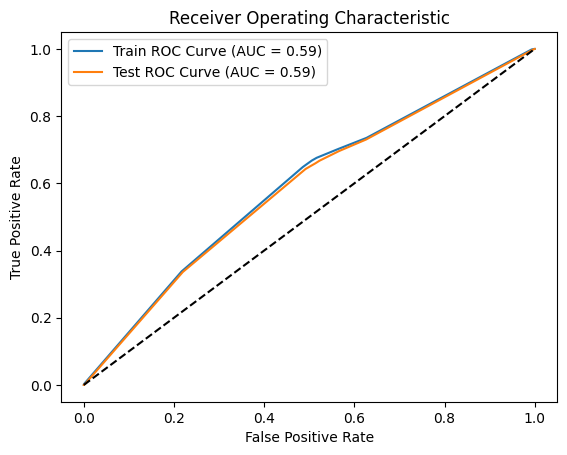

In [ ]:
# Calcula las probabilidades de predicción para las clases positivas del conjunto de entrenamiento y prueba:
y_train_probs = knn.predict_proba(X_train_scaled)[:, 1]
y_test_probs = knn.predict_proba(X_test_scaled)[:, 1]

# Calcula los valores de los puntos de la curva ROC para el conjunto de entrenamiento y prueba:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

# Calcula el área bajo la curva ROC para el conjunto de entrenamiento y prueba:
auc_train = roc_auc_score(y_train, y_train_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

#Graficar ROC
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC Curve (AUC = {:.2f})'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

### **2.1 - KNN (K-Vecinos Más Cercanos) con Oversampling**

In [ ]:
# Dividir los datos en variables independientes (X) y variable objetivo (y)
X = df_respaldo_clas[['RLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimaryPistol']]
y = df_respaldo_clas['MatchWinner']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar oversampling al conjunto de entrenamiento
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

# Crear y entrenar el modelo KNN con los datos de oversampling
knn_oversampled = KNeighborsClassifier(n_neighbors=20)
knn_oversampled.fit(X_train_resampled, y_train_resampled)

# Realizar predicciones en el conjunto de entrenamiento y prueba
y_train_pred = knn_oversampled.predict(X_train_resampled)
y_test_pred = knn_oversampled.predict(X_test_scaled)

# Guardar el StandardScaler ajustado en el archivo scaler.joblib
dump(scaler, 'scaler.joblib')

# Calcular métricas de desempeño para el conjunto de entrenamiento y prueba
train_cm = confusion_matrix(y_train_resampled, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_recall = recall_score(y_train_resampled, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
train_precision = precision_score(y_train_resampled, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
train_f1 = f1_score(y_train_resampled, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Imprimir las métricas de desempeño
print("Métricas de entrenamiento:")
print("Matriz de Confusión:")
print(train_cm)
print("Accuracy:", train_accuracy)
print("Recall:", train_recall)
print("Precision:", train_precision)
print("F1 Score:", train_f1)
print("\n")
print("Métricas de prueba:")
print("Matriz de Confusión:")
print(test_cm)
print("Accuracy:", test_accuracy)
print("Recall:", test_recall)
print("Precision:", test_precision)
print("F1 Score:", test_f1)

Métricas de entrenamiento:
Matriz de Confusión:
[[17123 16440]
 [11593 21970]]
Accuracy: 0.5823823853648363
Recall: 0.6545898757560409
Precision: 0.5719864618588909
F1 Score: 0.6105067177969518


Métricas de prueba:
Matriz de Confusión:
[[4259 4196]
 [2615 4762]]
Accuracy: 0.5697953511874684
Recall: 0.6455198590212824
Precision: 0.531591873185979
F1 Score: 0.5830425466789103


**Reportes de Clasificación**

In [ ]:
#Reporte de Entrenamiento
print(classification_report(y_train_resampled, y_train_pred))

              precision    recall  f1-score   support

       False       0.60      0.51      0.55     33563
        True       0.57      0.65      0.61     33563

    accuracy                           0.58     67126
   macro avg       0.58      0.58      0.58     67126
weighted avg       0.58      0.58      0.58     67126



In [ ]:
#Reporte de Prueba
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.62      0.50      0.56      8455
        True       0.53      0.65      0.58      7377

    accuracy                           0.57     15832
   macro avg       0.58      0.57      0.57     15832
weighted avg       0.58      0.57      0.57     15832



**Curva ROC de Entrenamiento y Prueba con Oversampling**

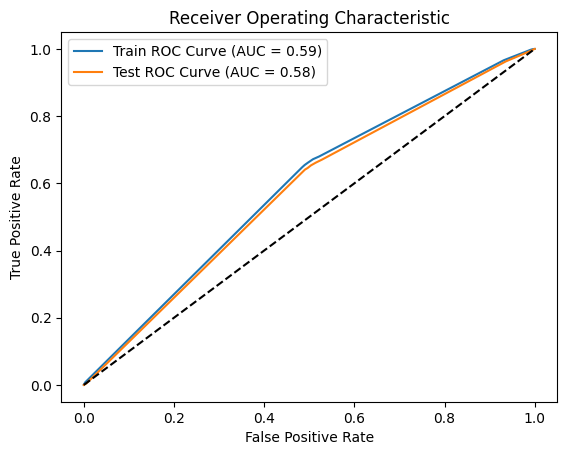

In [ ]:
# Calcula las probabilidades de predicción para las clases positivas del conjunto de entrenamiento y prueba:
y_train_probs = knn_oversampled.predict_proba(X_train_resampled)[:, 1]
y_test_probs = knn_oversampled.predict_proba(X_test_scaled)[:, 1]

# Calcula los valores de los puntos de la curva ROC para el conjunto de entrenamiento y prueba:
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

# Calcula el área bajo la curva ROC para el conjunto de entrenamiento y prueba:
auc_train = roc_auc_score(y_train_resampled, y_train_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

#Graficar ROC
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC Curve (AUC = {:.2f})'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

### **3 - Regresión Logística**



In [ ]:
# Definir las variables independientes (X) y la variable objetivo (y)
X = df_respaldo_clas[['RLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimaryPistol']]
y = df_respaldo_clas['MatchWinner']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Crear una instancia de StandardScaler
scaler = StandardScaler()

#Ajustar el StandardScaler a los datos de entrenamiento
scaler.fit(X_train)

#Transformar los datos de entrenamiento y prueba utilizando el StandardScaler ajustado
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo de regresión logística
logreg_model = LogisticRegression()

# Entrenar el modelo en el conjunto de entrenamiento
logreg_model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de entrenamiento y prueba
y_train_pred = logreg_model.predict(X_train_scaled)
y_test_pred = logreg_model.predict(X_test_scaled)

#Guardar el StandardScaler ajustado en el archivo scaler.joblib
dump(scaler, 'scaler.joblib')

['scaler.joblib']

**Métricas de Desempeño de Entrenamiento y Prueba**

In [ ]:
# Calcular métricas de desempeño para el conjunto de entrenamiento y prueba
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Imprimir las métricas de desempeño
print("Métricas de entrenamiento:")
print("Matriz de Confusión:")
print(train_cm)
print("Accuracy:", train_accuracy)
print("Recall:", train_recall)
print("Precision:", train_precision)
print("F1 Score:", train_f1)
print("\n")
print("Métricas de prueba:")
print("Matriz de Confusión:")
print(test_cm)
print("Accuracy:", test_accuracy)
print("Recall:", test_recall)
print("Precision:", test_precision)
print("F1 Score:", test_f1)

Métricas de entrenamiento:
Matriz de Confusión:
[[18996 14567]
 [12228 17534]]
Accuracy: 0.5768653770232925
Recall: 0.5891405147503528
Precision: 0.5462135135977072
F1 Score: 0.5668654931057336


Métricas de prueba:
Matriz de Confusión:
[[4759 3696]
 [3030 4347]]
Accuracy: 0.5751642243557352
Recall: 0.5892639284261895
Precision: 0.5404699738903395
F1 Score: 0.5638132295719844


#### **Reporte de Clasificación**

**Entrenamiento:**

In [ ]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

       False       0.61      0.57      0.59     33563
        True       0.55      0.59      0.57     29762

    accuracy                           0.58     63325
   macro avg       0.58      0.58      0.58     63325
weighted avg       0.58      0.58      0.58     63325



**Prueba:**

In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.61      0.56      0.59      8455
        True       0.54      0.59      0.56      7377

    accuracy                           0.58     15832
   macro avg       0.58      0.58      0.57     15832
weighted avg       0.58      0.58      0.58     15832



**Curva ROC de Entrenamiento y Prueba**

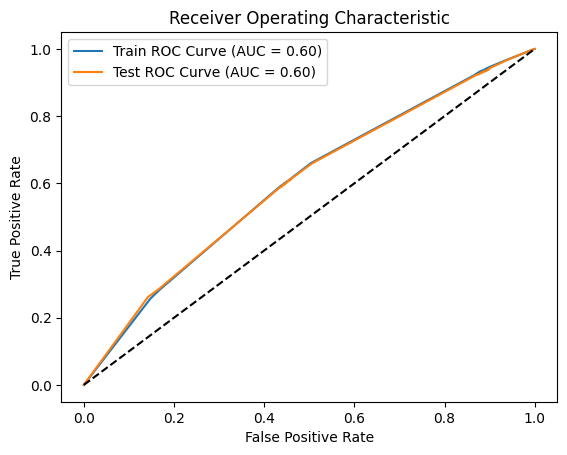

In [ ]:
# Calcula las probabilidades de predicción para las clases positivas del conjunto de entrenamiento y prueba:
y_train_probs = logreg_model.predict_proba(X_train_scaled)[:, 1]
y_test_probs = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Calcula los valores de los puntos de la curva ROC para el conjunto de entrenamiento y prueba:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

# Calcula el área bajo la curva ROC para el conjunto de entrenamiento y prueba:
auc_train = roc_auc_score(y_train, y_train_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

#Graficar ROC
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC Curve (AUC = {:.2f})'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

### **3.1 - Regresión Logística con Oversampling**


In [ ]:
# Definir las variables independientes (X) y la variable objetivo (y)
X = df_respaldo_clas[['RLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimaryPistol']]
y = df_respaldo_clas['MatchWinner']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear una instancia de StandardScaler
scaler = StandardScaler()

# Ajustar el StandardScaler a los datos de entrenamiento
scaler.fit(X_train)

# Transformar los datos de entrenamiento y prueba utilizando el StandardScaler ajustado
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Concatenar X_train y y_train para realizar el oversampling
training_data = pd.concat([X_train, y_train], axis=1)

# Separar las instancias de las clases mayoritaria y minoritaria
majority_class = training_data[training_data['MatchWinner'] == False]
minority_class = training_data[training_data['MatchWinner'] == True]

# Realizar el oversampling de la clase minoritaria
minority_oversampled = resample(minority_class,
                                replace=True,  # Reemplazar las instancias muestreadas
                                n_samples=len(majority_class),  # Igualar el número de instancias a la clase mayoritaria
                                random_state=42)

# Combinar las clases mayoritaria y minoritaria oversampleada
oversampled_data = pd.concat([majority_class, minority_oversampled])

# Separar nuevamente las variables independientes (X) y la variable objetivo (y) en el conjunto de entrenamiento oversampleado
X_train_oversampled = oversampled_data[['RLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimaryPistol']]
y_train_oversampled = oversampled_data['MatchWinner']

# Escalar los datos con el StandardScaler ajustado previamente
X_train_scaled_oversampled = scaler.transform(X_train_oversampled)

# Crear un nuevo modelo de regresión logística
logreg_model_oversampled = LogisticRegression()

# Entrenar el modelo con los datos oversampleados
logreg_model_oversampled.fit(X_train_scaled_oversampled, y_train_oversampled)

# Realizar predicciones en el conjunto de entrenamiento y prueba
y_train_pred_oversampled = logreg_model_oversampled.predict(X_train_scaled_oversampled)
y_test_pred_oversampled = logreg_model_oversampled.predict(X_test_scaled)

In [ ]:
# Calcular métricas de desempeño para el conjunto de entrenamiento y prueba con oversampling
train_cm_oversampled = confusion_matrix(y_train_oversampled, y_train_pred_oversampled)
test_cm_oversampled = confusion_matrix(y_test, y_test_pred_oversampled)
train_accuracy_oversampled = accuracy_score(y_train_oversampled, y_train_pred_oversampled)
test_accuracy_oversampled = accuracy_score(y_test, y_test_pred_oversampled)
train_recall_oversampled = recall_score(y_train_oversampled, y_train_pred_oversampled)
test_recall_oversampled = recall_score(y_test, y_test_pred_oversampled)
train_precision_oversampled = precision_score(y_train_oversampled, y_train_pred_oversampled)
test_precision_oversampled = precision_score(y_test, y_test_pred_oversampled)
train_f1_oversampled = f1_score(y_train_oversampled, y_train_pred_oversampled)
test_f1_oversampled = f1_score(y_test, y_test_pred_oversampled)

# Imprimir las métricas de desempeño con oversampling en el conjunto de entrenamiento
print("Métricas de entrenamiento con oversampling:")
print("Matriz de Confusión:")
print(train_cm_oversampled)
print("Accuracy:", train_accuracy_oversampled)
print("Recall:", train_recall_oversampled)
print("Precision:", train_precision_oversampled)
print("F1 Score:", train_f1_oversampled)
print("\n")

# Imprimir las métricas de desempeño con oversampling en el conjunto de prueba
print("Métricas de prueba con oversampling:")
print("Matriz de Confusión:")
print(test_cm_oversampled)
print("Accuracy:", test_accuracy_oversampled)
print("Recall:", test_recall_oversampled)
print("Precision:", test_precision_oversampled)
print("F1 Score:", test_f1_oversampled)

Métricas de entrenamiento con oversampling:
Matriz de Confusión:
[[18572 14991]
 [13344 20219]]
Accuracy: 0.5778833834877692
Recall: 0.6024193308107142
Precision: 0.5742402726498154
F1 Score: 0.5879923807308102


Métricas de prueba con oversampling:
Matriz de Confusión:
[[4653 3802]
 [2934 4443]]
Accuracy: 0.5745325922182921
Recall: 0.6022773485156567
Precision: 0.5388720436628259
F1 Score: 0.5688132121367303


**Curva ROC de Entrenamiento y Prueba con Modelo Oversampleado**

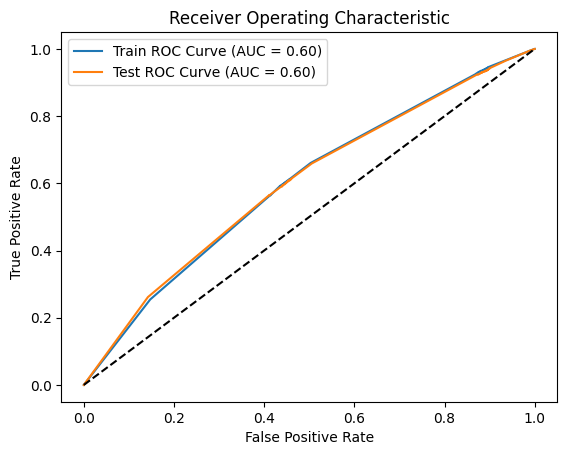

In [ ]:
# Calcula las probabilidades de predicción para las clases positivas del conjunto de entrenamiento y prueba:
y_train_probs = logreg_model_oversampled.predict_proba(X_train_scaled_oversampled)[:, 1]
y_test_probs = logreg_model_oversampled.predict_proba(X_test_scaled)[:, 1]

# Calcula los valores de los puntos de la curva ROC para el conjunto de entrenamiento y prueba:
fpr_train, tpr_train, _ = roc_curve(y_train_oversampled, y_train_probs)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

# Calcula el área bajo la curva ROC para el conjunto de entrenamiento y prueba:
auc_train = roc_auc_score(y_train_oversampled, y_train_probs)
auc_test = roc_auc_score(y_test, y_test_probs)

#Graficar ROC
plt.plot(fpr_train, tpr_train, label='Train ROC Curve (AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC Curve (AUC = {:.2f})'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

### **Comparación definitiva del área bajo la curva de cada modelo**

In [ ]:
# Calcular las probabilidades de clase para cada modelo:
y_prob_rf = rf_classifier_oversampled.predict_proba(X_test_scaled)[:, 1]
y_prob_knn = knn_oversampled.predict_proba(X_test_scaled)[:, 1]
y_prob_logreg = logreg_model_oversampled.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Calcular las curvas ROC para cada modelo:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)

In [ ]:
# Calcular el área bajo la curva ROC (AUC-ROC) para cada modelo
auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_knn = roc_auc_score(y_test, y_prob_knn)
auc_logreg = roc_auc_score(y_test, y_prob_logreg)

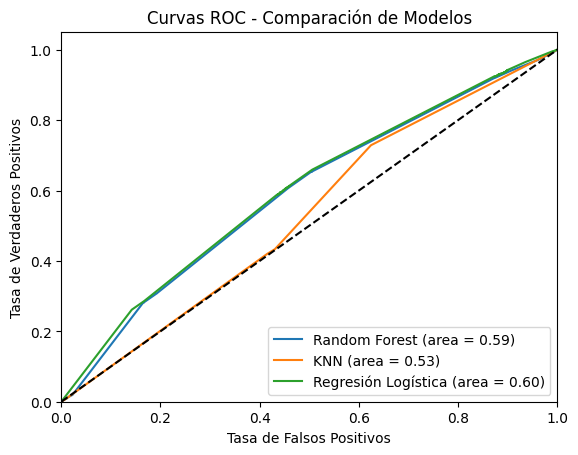

In [ ]:
# Graficar las curvas ROC juntas:
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % auc_rf)
plt.plot(fpr_knn, tpr_knn, label='KNN (area = %0.2f)' % auc_knn)
plt.plot(fpr_logreg, tpr_logreg, label='Regresión Logística (area = %0.2f)' % auc_logreg)

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC - Comparación de Modelos')
plt.legend(loc="lower right")
plt.show()

# **Fase 5 - Evaluación**

## **Métricas de Modelos de Regresión**

Esta siguiente fase contempla las metricas de regresión R^2, MAE, MSE y RMSE tanto de las métricas de entrenamiento, como las métricas de prueba obtenidas en cada modelo.

### **Métricas de Entrenamiento**

#### **Regresión Lineal Simple**

*   **Coeficiente de determinación (R^2):** El R^2 es 0.6215. Esto sugiere que alrededor del 62.16% de la variabilidad del porcentaje de uso de arma principal en el conjunto de entrenamiento puede ser explicada por el modelo de regresión.
*   **Error absoluto medio (MAE):** El MAE es 0.0972. Esto indica que, en promedio, las predicciones del modelo tienen un error absoluto de aproximadamente 0.0972 en relación al porcentaje de uso de arma principal real en el conjunto de entrenamiento, este es un nivel aceptable de precisión en la predicción del porcentaje de uso de arma principal en cuanto a la magnitud promedio de los errores de predicción.
*   **Error cuadrático medio (MSE):** indica que, en promedio, las predicciones del modelo tienen un error cuadrático de aproximadamente 0.0169 unidades al cuadrado con respecto a los valores reales de porcentaje de uso de arma en el conjunto de entrenamiento del modelo. este mse indica que el modelo tiene un buen ajuste a los datos de entrenamiento en la predicción del porcentaje de uso de arma principal.
*   **Error cuadrático medio (RMSE):** El RMSE es 0.1303. este RMSE  indica que el modelo tiene un nivel aceptable de precisión en la predicción del porcentaje de uso de arma.


#### **Support Vector Regresion**



*   Coeficiente de determinación (R^2): El valor del R^2 es -2.588, lo que significa que el modelo de regresión no se ajusta bien a los datos. Por su valor negativo, el modelo es peor que un simple modelo promedio. el modelo no es capaz de explicar la variabilidad de los datos y no realiza predicciones precisas.

*   Error absoluto medio (MAE): El valor del MAE es 0.7203, en promedio, hay una diferencia absoluta de 0.7203 unidades entre los valores reales y los valores predichos por el modelo. el MAE alto implica una discrepancia entre los valores reales y los valores predichos, por lo que el modelo tiene un desempeño deficiente.

*   Error cuadrático medio (MSE): El valor del MSE es 0.6436, que representa el promedio de los errores cuadráticos entre los valores reales y los valores predichos. Su MSE es alto, por lo que tiene una gran dispersión de los errores cuadráticos, este modelo tiene un ajuste deficiente y hace predicciones inexactas.

*   Raíz del error cuadrático medio (RMSE): El valor del RMSE es 0.8023, que es la raíz cuadrada del MSE. Esto representa el promedio de los errores entre los valores reales y los valores predichos. Al ser un valor alto, el modelo tiene un desempeño deficiente.











#### **Árbol de Decisión de Regresión**

*   **Coeficiente de determinación (R^2)**: En este caso, el valor de R^2 en el conjunto de entrenamiento es 0.738482333924044. Esto significa que aproximadamente el 73.85% de la variabilidad de la variable dependiente puede ser explicada por nuestras variables independientes en el conjunto de entrenamiento.

*   **Error absoluto medio (MAE)**: En este caso, el valor de MAE en el conjunto de entrenamiento es 0.04706749760318976. El MAE representa la magnitud promedio de los errores absolutos entre las predicciones del modelo y los valores reales en el conjunto de entrenamiento.

*   **Error cuadrático medio (MSE)**: El valor de MSE en el conjunto de entrenamiento es 0.01168979785280743. El MSE mide el promedio de los errores al cuadrado entre las predicciones del modelo y los valores reales en el conjunto de entrenamiento.

*   **Raíz del error cuadrático medio (RMSE)**: En este caso, el valor de RMSE en el conjunto de entrenamiento es 0.10811936853685111. El RMSE es la raíz cuadrada del MSE y representa la desviación estándar de los errores del modelo en el conjunto de entrenamiento.











### **Métricas de Prueba**

#### **Regresión Lineal Simple**

*   El **Coeficiente de determinación (R^2)** de 0.6308 indica que un 63.08% de la variabilidad de la variable dependiente puede ser explicada por el modelo de regresión. Su valor no es tan cercano a 1, por lo que el modelo cuenta con un ajuste medio.

*   El **Error absoluto medio (MAE)** de 0.0960 representa la diferencia promedio absoluta entre los valores reales y los valores predichos por el modelo. En promedio, hay una diferencia de 0.0960 unidades entre los valores reales y los valores predichos. Un MAE más bajo indica una mejor precisión del modelo.

*   El **Error cuadrático medio (MSE)** de 0.0164 representa el promedio de los errores al cuadrado entre los valores reales y los valores predichos. Es una medida de la calidad del ajuste del modelo y se ve afectado por valores atípicos y errores grandes. Un MSE más bajo indica una mejor precisión del modelo.

*   La **Raíz del error cuadrático medio (RMSE)** de 0.1284 indica que en promedio, el error entre los valores reales y los valores predichos es de aproximadamente 0.1284 unidades. Este RMSE indica una buena precisión del modelo.

#### **Support Vector Regression:**



*   El valor del **Coeficiente de determinación (R^2)** es 0.6587, esto significa que el 65.87% de la variabilidad de la variable dependiente se puede explicar por el modelo de SVR. Su valor es tan cercano a 1, por lo que el modelo cuenta con un ajuste medio.

*   **El Error Absoluto Medio (MAE)** mide la diferencia promedio entre los valores reales de la variable dependiente y los valores predichos por el modelo. En este caso, en promedio, cuenta con una diferencia absoluta de 0.1514 unidades entre los valores reales y los valores predichos por el modelo de Support Vector Regression. Su valor es bajo, por lo que indica una buena precisión.

*   **El Error Cuadrático Medio (MSE)** contempla la diferencia al cuadrado entre los valores reales y los valores predichos. En este caso, el valor del MSE es 0.0609, lo que significa que, en promedio, el error cuadrático entre los valores reales y los valores predichos es de 0.0609 unidades.

*   La **Raíz del error cuadrático medio (RMSE)**, que es la raíz cuadrada del MSE, sirve para tener una métrica en la misma escala que la variable dependiente. En el SVR su valor es de 0.2469, quiere decir que en promedio, el error entre los valores reales y los valores predichos es de aproximadamente 0.2469 unidades. Al tener un valor bajo, cuenta con una buena precisión.







#### **Árbol de Decisión de Regresión:**


*   Su **coeficiente de determinación (R^2)** es 0.7464, que indica el 74.64% de variabilidad de la variable dependiente. Su valor es decente porque es el que más cercano se encuentra de 1, por lo que su ajuste es bueno.

*   El **Error Absoluto Medio (MAE)** de 0.0462 es un valor bajo, cuenta con una diferencia absoluta de 0.0462 unidades entre los valores reales y los valores predichos. Por lo que al ser un valor bajísimo, cuenta con una buena precisión.

*   Su **Error cuadrático medio (MSE)** es de 0.0113, esto quiere decir que en promedio, el error cuadrático entre los valores reales y los valores predichos por el modelo de árbol de decisión es de 0.0113 unidades. Su valor bajo indica una menor diferencia al cuadrado entre los valores reales y los valores predichos.

*   La **Raíz del Error Cuadrático Medio (RMSE)** es de 0.1064, esto quiere decir que en promedio, el error entre los valores reales y los valores predichos por el modelo de árbol de decisión es de 0.1064 unidades. En esta medida, su bajo valor indica una mayor precisión en las predicciones por encima de los demás modelos.











### **Conclusiones Finales**

De los 3 modelos de regresión creados, quién tiene mejores métricas de prueba es el **Árbol de Decisión de Regresión** ya que tiene valores más altos en el **Coeficiente de determinación (R^2)** y menores en las **métricas de error (MAE, MSE, RMSE).**

*   Debido a que su Coeficiente de Determinación (R^2) de **0.7464** es el más cercano a 1, por encima de los resultados del modelo de regresión lineal y del SVR, cuyos valores inferiores son 0.6308 y 0.6587 respectivamente.

*   Con respecto al Error Absoluto Medio (MAE), cuanto más bajo, mejor. Aquí, el Árbol de regresión tiene el valor más bajo de 0.0462, lo que significa que su diferencia promedio entre las predicciones y los valores reales es la menor por encima de los resultados del modelo de regresión lineal y del SVR, cuyos valores son 0.0960 y 0.1514 respectivamente.

*   En cuanto al **Error Cuadrático Medio (MSE)** cuanto más bajo, mejor. El Árbol de Regresión también cuenta con el valor más bajo de 0.0113, lo que quiere decir que este modelo tiene la menor dispersión de errores cuadráticos promedio, en comparación a los resultados del modelo de regresión lineal y del SVR, cuyos valores son 0.0164 y 0.0609 respectivamente.

*   Con respecto a la Raíz del Error Cuadrático Medio (RMSE) nuevamente, cuanto más bajo, mejor. El valor más bajo de 0.1064 corresponde al Árbol de Regresión, en comparación a las métricas resultantes del modelo de regresión lineal y del SVR, cuyos valores son 0.1284 y 0.2469 respectivamente.

## **Métricas de Modelos de Clasificación**

### **Random Forest de Clasificación**

Interpretación de las métricas de desempeño en el modelo de clasificación RandomForest:


* **Matriz de Confusión:**

    *   **Entrenamiento:** La matriz de confusión muestra que en el conjunto de entrenamiento se tienen 17,531 verdaderos positivos (instancias correctamente clasificadas como positivas), 16,032 falsos negativos (instancias incorrectamente clasificadas como negativas), 10,549 falsos positivos (instancias incorrectamente clasificadas como positivas) y 23,014 verdaderos negativos (instancias correctamente clasificadas como negativas).

    *   **Prueba:** La matriz de confusión muestra que en el conjunto de prueba se tienen 4,577 verdaderos positivos, 3,878 falsos negativos, 2,892 falsos positivos y 4,485 verdaderos negativos.

*  **Accuracy (Exactitud):**

    *   **Entrenamiento:** La exactitud en el conjunto de entrenamiento es de 0.604, lo que indica que el modelo clasifica correctamente el 60.4% de las instancias en el conjunto de entrenamiento.

    *   **Prueba:** La exactitud en el conjunto de prueba es de 0.572, lo que indica que el modelo clasifica correctamente el 57.2% de las instancias en el conjunto de prueba.

*  **Precision:**

    *   **Entrenamiento:** La precisión en el conjunto de entrenamiento es de 0.589, lo que significa que el 58.9% de las instancias clasificadas como positivas son realmente positivas.

    *   **Prueba:** La precisión en el conjunto de prueba es de 0.536, lo que significa que el 53.6% de las instancias clasificadas como positivas son realmente positivas.

*  **F1 Score:**

    *   **Entrenamiento:** El valor de F1-score en el conjunto de entrenamiento es de 0.634, lo que representa una medida combinada de precisión y exhaustividad del modelo. Cuanto más cercano a 1, mejor es el rendimiento del modelo.

    *   **Prueba:**  El valor de F1-score en el conjunto de prueba es de 0.570, lo que indica un buen equilibrio entre precisión y exhaustividad del modelo en el conjunto de prueba.

*  **Curva ROC:**

    *   Entrenamiento: El área bajo la curva es de 0.664. Esto indica que el modelo es capaz de clasificar correctamente aproximadamente el 66.4% de los pares de ejemplos positivos y negativos.

    *   **Prueba:** El área bajo la curva es de 0.59. Esto indica que el modelo puede clasificar correctamente aproximadamente el 59% de los pares de ejemplos positivos y negativos en el conjunto de prueba.

En resumen, el modelo con oversampling muestra un rendimiento mejorado en comparación con las métricas anteriores. La exactitud, precisión y F1-score han mejorado en ambos conjuntos (entrenamiento y prueba) en comparación con el modelo sin oversampling. El área bajo la curva (AUC) en la curva ROC se mantiene, lo que indica una capacidad media de clasificación del modelo.


### **KNN (k-Vecinos Más Cercanos)**

Interpretaciones de las métricas de entrenamiento y prueba del modelo de clasificación KNN:


*   **Matriz de Confusión:**

  *   **Entrenamiento:** La matriz de confusión muestra que en el conjunto de entrenamiento se tienen 17123 verdaderos positivos, 16440 falsos negativos, 11593 falsos positivos y 21970 verdaderos negativos.

  *   **Prueba:** La matriz de confusión muestra que en el conjunto de prueba se tienen 4259 verdaderos positivos, 4196 falsos negativos, 2615 falsos positivos y 4762 verdaderos negativos.

*   **Accuracy:**

  *   **Entrenamiento:** La exactitud en el conjunto de entrenamiento es de 0.58, lo que indica que el modelo clasifica correctamente el 58% de las instancias en el conjunto de entrenamiento.

  *   **Prueba:** La exactitud en el conjunto de prueba es de 0.56, lo que indica que el modelo clasifica correctamente el 56% de las instancias en el conjunto de prueba.

*   **Recall (Exactitud):**
  *   **Entrenamiento:** El recall de entrenamiento es 0.65, el modelo pudo identificar correctamente el 65% de ejemplos positivos.
  *   **Prueba:** El recall de entrenamiento es 0.64, el modelo pudo identificar correctamente el 64% de ejemplos positivos.


*   **Precision:**

  *   **Entrenamiento:** La precisión en el conjunto de entrenamiento es de 0.57, lo que significa que el 57% de las instancias clasificadas como positivas son realmente positivas.

  *   **Prueba:** La precisión en el conjunto de prueba es de 0.53, lo que significa que el 53% de las instancias clasificadas como positivas son realmente positivas.

*   **F1 Score:**

  *   **Entrenamiento:** El valor de F1-score en el conjunto de entrenamiento es de 0.61, lo que representa una medida combinada de precisión y exhaustividad del modelo. Cuanto más cercano a 1, mejor es el rendimiento del modelo.

  *   **Prueba:** El valor de F1-score en el conjunto de prueba es de 0.58, lo que indica un rendimiento moderado en términos de precisión y exhaustividad del modelo en el conjunto de prueba.

*   **Curva ROC:**
  *   **Entrenamiento:** El área bajo la curva es de 0.54. Esto indica indica que el modelo puede clasificar correctamente aproximadamente el 60% de los pares de ejemplos positivos y negativos en el conjunto de prueba.

  *   **Prueba:** El área bajo la curva es de 0.53. Esto indica indica que el modelo puede clasificar correctamente aproximadamente el 59% de los pares de ejemplos positivos y negativos en el conjunto de prueba.


El KNN muestra un rendimiento similar en las métricas de entrenamiento y prueba, con valores cercanos en exactitud, precisión y F1-score. Sin embargo, los valores de estas métricas son relativamente medios, lo que indica que el modelo es capaz de clasificar .

### **Regresión Logística**

Interpretaciones de las métricas de entrenamiento y prueba del modelo de clasificación Rregresion logistica:


*   **Matriz de Confusión:**

  *   **Entrenamiento:** Matriz de Confusión: La matriz de confusión muestra que hay 18,572 verdaderos positivos, 14,991 falsos negativos, 13,344 falsos positivos y 20,219 verdaderos negativos.

  *   **Prueba:** La matriz de confusión muestra que hay 4,653 verdaderos positivos, 3,802 falsos negativos, 2,934 falsos positivos y 4,443 verdaderos negativos.

*   **Accuracy (Exactitud):**
  *   **Entrenamiento:** Accuracy (Exactitud): La exactitud es de 0.578, lo que significa que el modelo clasifica correctamente el 57.8% de las instancias en el conjunto de entrenamiento.
  *   **Prueba:**  La exactitud es de 0.575, lo que significa que el modelo clasifica correctamente el 57.5% de las instancias en el conjunto de prueba.

*   **Recall:**
  *   **Entrenamiento:** El valor de recall es de 0.602, lo que indica que el modelo identifica correctamente el 60.2% de las instancias positivas en el conjunto de entrenamiento.
  *   **Prueba:**  El valor de recall es de 0.602, lo que indica que el modelo identifica correctamente el 60.2% de las instancias positivas en el conjunto de prueba.



*   **Precision:**
  *   **Entrenamiento:** La precisión es de 0.574, lo que significa que el 57.4% de las instancias clasificadas como positivas son realmente positivas.
  *   **Prueba:**  La precisión es de 0.539, lo que significa que el 53.9% de las instancias clasificadas como positivas son realmente positivas.

*   **F1 Score:**
  *   **Entrenamiento:** El valor de F1-score es de 0.588, lo que indica un buen equilibrio entre precisión y exhaustividad del modelo en el conjunto de entrenamiento.
  *   **Prueba:** El valor de F1-score es de 0.569, lo que indica un buen equilibrio entre precisión y exhaustividad del modelo en el conjunto de prueba.

*   **Curva ROC:**
  *   **Entrenamiento:** El área bajo la curva es de 0.60. El modelo es capaz de clasificar correctamente aproximadamente el 59% de los pares de ejemplos positivos y negativos.

  *   **Prueba:** El área bajo la curva es de 0.60. El modelo puede clasificar correctamente aproximadamente el 59% de los pares de ejemplos positivos y negativos.

La regresión logística muestra un rendimiento similar en las métricas de entrenamiento y prueba, con valores cercanos en exactitud, precisión y F1-score. La exactitud general es relativamente buena, indicando que el modelo es capaz de clasificar correctamente una gran proporción de las instancias en ambos conjuntos. Sin embargo, la precisión y el F1-score son ligeramente más bajos, lo que sugiere que el modelo puede tener dificultades para clasificar de manera precisa las instancias positivas.

### **Conclusión Definitiva**

En conclusión, los 3 modelos mejorados con oversampling muestran rendimiento similar en términos de métricas de evaluación, siendo los 3 equilibrados. El Random Forest, el KNN y la Regresión Logística tuvieron una exactitud de 56%, 57% y 56% respectivamente tanto durante el entrenamiento como en la prueba, Los modelos en general tienen un desempeño deficiente, debido a que el área bajo la curva de cada uno no está ni cerca de 1.

# **Fase 6 - Deployment**

En al fase de producción fueron incluidos formularios en el mismo Colab, junto con la exportación de archivos PKL para trabajarse en la aplicación web de Flask.

## **Formularios en Colab**

A continuación se muestran formularios de inserción desde colab para hacer predicciones de cada modelo:

### **Modelos de Regresión**

#### **Insertar predicción de Regresión Lineal:**

In [ ]:
prediccion = input("Inserte valor del equipaje inicial: ")
prediccion = int(prediccion)
print('El porcentaje de probabilidad de usar un rifle teniendo un valor de equipaje inicial de', prediccion ,'$ es de un :' , (y_pred_reglineal[prediccion]  * 100), '%')

Inserte valor del equipaje inicial: 3000
El porcentaje de probabilidad de usar un rifle teniendo un valor de equipaje inicial de 3000 $ es de un : [51.87699265] %


#### **Insertar predicción de SVR:**

In [ ]:
prediccion = input("Inserte valor del equipaje inicial: ")
prediccion = int(prediccion)
print('El porcentaje de probabilidad de usar un rifle teniendo un valor de equipaje inicial de', prediccion ,'$ es de un :' , (y_pred_svr[prediccion]  * 100), '%')

Inserte valor del equipaje inicial: 5000
El porcentaje de probabilidad de usar un rifle teniendo un valor de equipaje inicial de 5000 $ es de un : [46.73272789] %


#### **Insertar Predicción de árbol de regresión**:

In [ ]:
prediccion = input("Inserte valor del equipaje inicial: ")
prediccion = int(prediccion)
print('El porcentaje de probabilidad de usar un rifle teniendo un valor de equipaje inicial de', prediccion ,'$ es de un :' , (Y_pred_arbol[prediccion]  * 100), '%')

Inserte valor del equipaje inicial: 4500
El porcentaje de probabilidad de usar un rifle teniendo un valor de equipaje inicial de 4500 $ es de un : 41.36476984403053 %


### **Modelos de Clasificación**

#### **Insertar Predicción en Random Forest**:

In [ ]:
porcRifle = input("Inserte el porcentaje de uso de rifle de asalto como arma primaria: ")
granadas = input("Inserte la cantidad de granadas letales lanzadas: ")
porcRifle = float(porcRifle)
granadas = int(granadas)
print('¿Ganó la partida?' , rf_classifier.predict([[porcRifle, granadas]]))

Inserte el porcentaje de uso de rifle de asalto como arma primaria: 0.22
Inserte la cantidad de granadas letales lanzadas: 9
¿Ganó la partida? [False]


#### **Insertar Predicción en KNN**:

In [ ]:
porcRifle = input("Inserte el porcentaje de uso de rifle de asalto como arma primaria: ")
granadas = input("Inserte la cantidad de granadas letales lanzadas: ")
porcRifle = float(porcRifle)
granadas = int(granadas)
print('¿Ganó la partida?' , knn.predict([[porcRifle, granadas]]))

Inserte el porcentaje de uso de rifle de asalto como arma primaria: 0.55
Inserte la cantidad de granadas letales lanzadas: 3
¿Ganó la partida? [False]


#### **Insertar Predicción en Regresión Logística**:

In [ ]:
porcRifle = input("Inserte el porcentaje de uso de rifle de asalto como arma primaria: ")
granadas = input("Inserte la cantidad de granadas letales lanzadas: ")
porcRifle = float(porcRifle)
granadas = int(granadas)
print('¿Ganó la partida?' , logreg_model.predict([[porcRifle, granadas]]))

Inserte el porcentaje de uso de rifle de asalto como arma primaria: 0.45
Inserte la cantidad de granadas letales lanzadas: 5
¿Ganó la partida? [False]


## **Exportación de Archivos PKL**

Exportación de modelos mejorados al formato .PKL con Pickle con el propósitos de ser trabajados mediante la aplicación web con Flask:

In [ ]:
archivo = 'randomforest.pkl'
pickle.dump(rf_classifier_oversampled, open(archivo, 'wb'))

In [ ]:
archivo = 'knn.pkl'
pickle.dump(knn_oversampled, open(archivo, 'wb'))

In [ ]:
archivo = 'logisticregression.pkl'
pickle.dump(logreg_model_oversampled, open(archivo, 'wb'))